# Trim all the data and build the train and dev data frames 

In [9]:
import numpy as np
import pandas as pd

# constants determined from online source 
# r_0 on data sheet is specified to be < 100 mOhms
# r_0 = 0.037 # (ohms) 
q_nom = 3.350 # (Ah)
c_p = 1058 # (farads)
r_p = 0.039 # (ohms)

c = np.exp(-1 / (c_p * r_p))

In [10]:
# get the data paths 
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
sns.set()

data_paths = glob.glob('data/*/*/*.csv')

In [11]:
# function to build a data frame from a path and include filename, discharge temp, discharge profile
def path_to_df(path):
    df_new = pd.read_csv(path)
    
    # add discharge temp, discharge profile, and filename to the df columns 
    discharge_temp, discharge_profile, filename = path.split('/')[1:]
    df_new['data_path'] = path 
    df_new['discharge_temp'] = discharge_temp
    df_new['discharge_profile'] = discharge_profile 
    df_new['filename'] = filename 
    
    # check to make sure columns match expected columns 
    expected_columns = ['time_s', 'voltage_v', 'current_a', 'chargecapacity_ah', \
       'dischargecapacity_ah', 'charge_energy_wh', 'discharge_energy_wh', \
       'voltagedot_v_per_s', 'temp_degc', 'discharge_temp', \
       'discharge_profile', 'filename']
    
    for expected_column in expected_columns:
        if expected_column not in df_new.columns:
            print('missing column in {}'.format(path))
            raise
    
    return df_new

# function to downsample UDDS and US06 and trim the "charge and hold" sections of all profiles 
def trim_df(df):
    
    # downsample for UDDS and US06 profiles 
    if df['discharge_profile'].iloc[0] in ['UDDS', 'US06']:
        df = df_new.iloc[::10, :].reset_index(drop=True)
         
    # get first negative current index 
    first_neg_cur_idx = df.where(df["current_a"]<0).first_valid_index()
    
    # get last index of fully charged state (4.2V) 
    trim_idx = df.iloc[0:first_neg_cur_idx, :].where(df["voltage_v"]==4.2).last_valid_index()
    
    # slice dataframe from fully charged state to end 
    df = df.iloc[trim_idx+1:, :]
    
    # reset time index to begin from fully charged state 
    df = df.reset_index(drop=True).reset_index().drop(columns="time_s").rename(columns={"index": "time_s"}) 
    
    return df
    
# function to build state equations from known constants 
def build_df_states(df):
    n = df['current_a'].size
    
    # state variables 
    soc = np.zeros(n)
    v_p = np.zeros(n)
    
    # initial states 
    soc[0] = 100
    v_p[0] = 0 # redundant but good to note (is this a safe assumption?)
    
    for i in range(1, n):
        soc[i] = soc[i-1] - (-1) * (1 / (q_nom * 3600)) * df['current_a'].iloc[i-1] * 100
        v_p[i] = c * v_p[i-1] + (-1) * r_p * (1 - c) * df['current_a'].iloc[i-1] 
        
    df['soc'] = soc 
    df['v_p'] = v_p 
        
    return df

In [29]:
# build the train and dev sets 

df_train = pd.DataFrame() 
df_dev = pd.DataFrame() 

dev_paths = [] 

for data_path in data_paths:
    df_new = path_to_df(data_path)
    
    df_new = trim_df(df_new)
    
    df_new = build_df_states(df_new)
    
    if 'US06' in data_path:
        dev_paths.append(data_path)
        df_dev = df_dev.append(df_new)
    else:
        df_train = df_train.append(df_new)

df_train = df_train.reset_index()
df_dev = df_dev.reset_index()

# Model Training 

## Circuit Model: Calculate Voc (via plots) and R0 (via LS) 

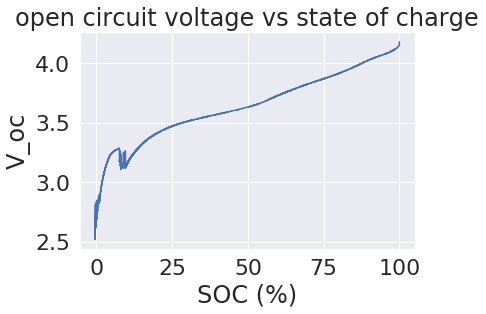

In [32]:
# calculate v_oc from 0_05C discharge profile -> V(SOC)
v_oc_levels = 1000
if (v_oc_levels % 10 != 0) or (v_oc_levels < 100):
    print('invalid number of bins specified for v_oc')
    raise

decimals = int(np.log(v_oc_levels / 100))

df_train['soc_rounded'] = df_train['soc'].round(decimals)
df_dev['soc_rounded'] = df_dev['soc'].round(decimals)

df_train_005C = df_train[df_train['discharge_profile'] == '0_05C']
v_oc = df_train_005C[['soc_rounded','voltage_v']].groupby('soc_rounded').mean()
v_oc = v_oc.rename(columns={"voltage_v": "v_oc"}).reset_index()

plt.plot(v_oc['soc_rounded'], v_oc['v_oc'])
plt.title('open circuit voltage vs state of charge')
plt.ylabel('V_oc')
plt.xlabel('SOC (%)')

if 'v_oc' in df_train.columns:
    df_train = df_train.drop(['v_oc'], axis=1)
if 'v_oc' in df_dev.columns:
    df_dev = df_dev.drop(['v_oc'], axis=1)

df_train = pd.merge(df_train, v_oc, how = 'left', on = 'soc_rounded')
df_dev = pd.merge(df_dev, v_oc, how = 'left', on = 'soc_rounded')

In [33]:
# calculate R0 using LS
A = np.zeros((df_train['current_a'].size,1))
A[:,0] = df_train['current_a']

y = np.zeros((df_train['voltage_v'].size,1))
y[:,0] = df_train['voltage_v']

b = np.zeros((df_train['voltage_v'].size,1))
b[:,0] = df_train['v_oc'] - df_train['v_p']

x = np.linalg.lstsq(A, y-b, rcond=None)
r_0 = x[0][0]
print('r_0 = {}'.format(r_0))

r_0 = [0.0502962]


## ML Models 

In [51]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

X_train = df_train[['data_path', 'current_a', 'soc', 'temp_degc']]
y_train = df_train[['data_path', 'voltage_v']]

X_dev = df_dev[['data_path', 'current_a', 'soc', 'temp_degc']]
y_dev = df_dev[['data_path', 'voltage_v']]

# Linear Regression 
print('fitting linear regression model')
model_reg = LinearRegression().fit(X_train[['current_a', 'soc','temp_degc']], y_train['voltage_v'])

# relu nn,
print('fitting relu nn model')
model_nn_relu = MLPRegressor(solver='adam', activation = 'relu', alpha=1e-5, verbose = True, \
                        hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive') \
                        .fit(X_train[['current_a', 'soc','temp_degc']], y_train['voltage_v'])

# tanh nn
print('fitting tanh nn model')
model_nn_tanh = MLPRegressor(solver='adam', activation = 'tanh', alpha=1e-5, verbose = True, \
                        hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive') \
                        .fit(X_train[['current_a', 'soc','temp_degc']], y_train['voltage_v'])

fitting linear regression model
fitting relu nn model
Iteration 1, loss = 0.01733405
Iteration 2, loss = 0.00136976
Iteration 3, loss = 0.00129926
Iteration 4, loss = 0.00126853
Iteration 5, loss = 0.00124130
Iteration 6, loss = 0.00117894
Iteration 7, loss = 0.00099003
Iteration 8, loss = 0.00095777
Iteration 9, loss = 0.00095849
Iteration 10, loss = 0.00094377
Iteration 11, loss = 0.00092550
Iteration 12, loss = 0.00091059
Iteration 13, loss = 0.00090780
Iteration 14, loss = 0.00090289
Iteration 15, loss = 0.00090191
Iteration 16, loss = 0.00090218
Iteration 17, loss = 0.00090000
Iteration 18, loss = 0.00089572
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
fitting tanh nn model
Iteration 1, loss = 0.03743762
Iteration 2, loss = 0.00086891
Iteration 3, loss = 0.00068116
Iteration 4, loss = 0.00062522
Iteration 5, loss = 0.00061044
Iteration 6, loss = 0.00060688
Iteration 7, loss = 0.00060146
Iteration 8, loss = 0.00059601
Iteration 9, loss =

In [52]:
# Recurrent Neural Network 

import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras import optimizers
from keras.callbacks import EarlyStopping

# function to convert dataframe data to windowed data that can be used by an RNN
# returns a numpy array 
def windowed_data(X, y, window_size):
    
    # lists to store each new row of data 
    X_windowed = []
    y_windowed = []
    
    # group X and y dataframe by data_path 
    X_grouped = X.groupby(X['data_path'])
    y_grouped = y.groupby(y['data_path'])
    
    # append rows to x and y data 
    for name, group, in X_grouped:
        X_windowed.append(windowed_data_helper(group[['current_a','soc','temp_degc']].values, window_size, True))
    
    for name, group in y_grouped:
        y_windowed.append(windowed_data_helper(group['voltage_v'].values, window_size, False))
        
    return np.vstack(X_windowed), np.vstack(y_windowed)

def windowed_data_helper(data, window_size, is_input):
    
    # need to create windowed data if input 
    if is_input:
        X_windowed = np.zeros((data.shape[0] - window_size + 1, window_size, data.shape[1]), dtype = 'float32')
        for sample_idx in range(0, data.shape[0] - window_size + 1):
            for feature_idx in range(0, data.shape[1]):
                X_windowed[sample_idx, :, feature_idx] = data[sample_idx:sample_idx + window_size, feature_idx]
                
        return X_windowed
    
    # need to leave out last window_size - 1 entries of output data 
    else:
        y_windowed = data[window_size-1:]
        y_windowed = y_windowed.reshape((y_windowed.shape[0],1))
        
        return y_windowed 

In [53]:
# fit a recurrent neural network 
print('windowing data')
lstm_window_size = 10
X_train_windowed, y_train_windowed = windowed_data(X_train, y_train, window_size = lstm_window_size)
X_dev_windowed, y_dev_windowed = windowed_data(X_dev, y_dev, window_size = lstm_window_size)

print('building lstm model')
model_lstm = Sequential()
model_lstm.add(LSTM(units=20, input_shape = (X_train_windowed.shape[1], X_train_windowed.shape[2]),
                    activation='tanh', recurrent_activation='sigmoid', use_bias=True, unit_forget_bias=True,
                    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                    dropout=0.0, recurrent_dropout=0.0, implementation=1,
                    return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False))
model_lstm.add(Dense(units=1, activation=None, use_bias=True, 
                     kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                     kernel_constraint=None, bias_constraint=None))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print('fitting lstm model')
es = EarlyStopping(monitor='val_loss', min_delta=0.000100, restore_best_weights=True)
model_lstm.fit(x=X_train_windowed, y=y_train_windowed, validation_data=[X_dev_windowed, y_dev_windowed], batch_size = 1024, epochs = 10, verbose=True, callbacks = [es])

windowing data
building lstm model
fitting lstm model
Train on 2463922 samples, validate on 146130 samples
Epoch 1/10
2463922/2463922 [==============================] - 127s 52us/step - loss: 0.4782 - val_loss: 9.8033e-04
Epoch 2/10
2463922/2463922 [==============================] - 122s 50us/step - loss: 0.0010 - val_loss: 9.0735e-04


# Model Testing 

In [192]:
# prediction results 
df_costs = pd.DataFrame(index = dev_paths, \
                        columns = ['circuit','reg','nn_relu','nn_tanh','lstm'])

## Circuit Testing

In [193]:
# Plot circuit results 
for dev_path in dev_paths:
    costs = pd.DataFrame(index = [df_dev['data_path'].unique()], columns = ['model'])

    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    
    cost = np.mean(np.power(voltage - v_hat,2))
    df_costs['circuit'].loc[dev_path] = cost 

    # plot circuit model components, predictions, and error 
#     fig=plt.figure(figsize=(18, 24))

#     plt.subplot(3,1,1)
#     plt.plot(v_oc)
#     plt.plot(v_p)
#     plt.plot((-1) * v_i)
#     plt.title('circuit model components: {}'.format(dev_path))
#     plt.legend(['v_oc', 'v_p', 'v_i'])

#     plt.subplot(3,1,2)
#     plt.plot(voltage)
#     plt.plot(v_hat)
#     plt.title('circuit model predictions: {}'.format(dev_path))
#     plt.legend(['voltage', 'V_hat'])

#     plt.subplot(3,1,3)
#     plt.plot(voltage - v_hat)
#     plt.title('circuit model errors: {}'.format(dev_path))

## ML Testing 

In [194]:
def ml_preds(model, X_dev, y_dev, df_cost, verbose = True, isLSTM = False, window_size = 10):
    for dev_path in y_dev['data_path'].unique():
        
        if isLSTM:
            print('windowing data') 
            X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],\
                                 y_dev[y_dev['data_path'] == dev_path],\
                                 window_size)     
        else:
            X = X_dev[['current_a','soc','temp_degc']][X_dev['data_path'] == dev_path].values
            y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values

        pred = model.predict(X).reshape(y.shape)
        
        cost = np.mean((pred - y) ** 2)
        df_cost.loc[dev_path] = cost 
        
        if verbose:
            fig=plt.figure(figsize=(18, 8))
            plt.plot(y)
            plt.plot(pred)
            plt.title(dev_path)
            plt.legend(['true voltage','predicted voltage'])

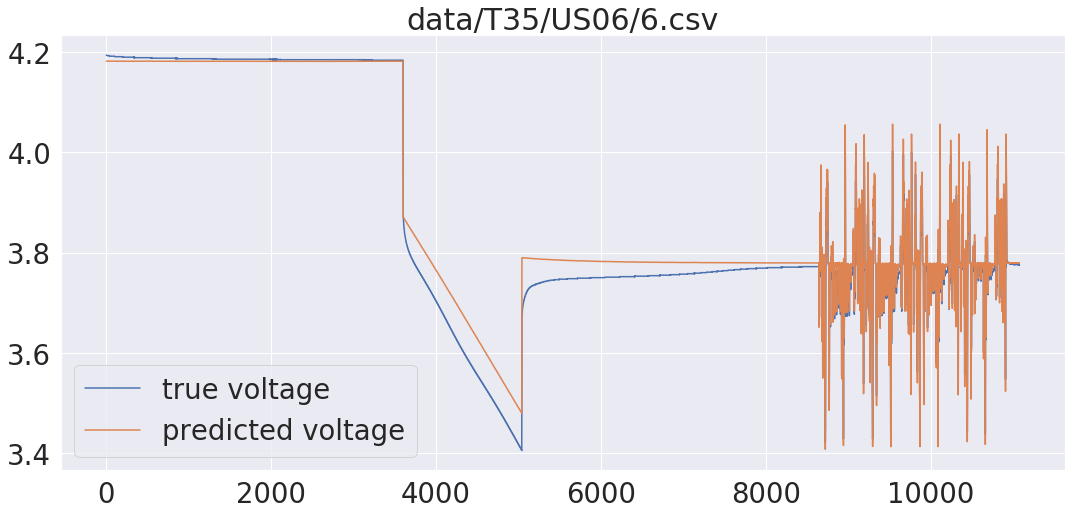

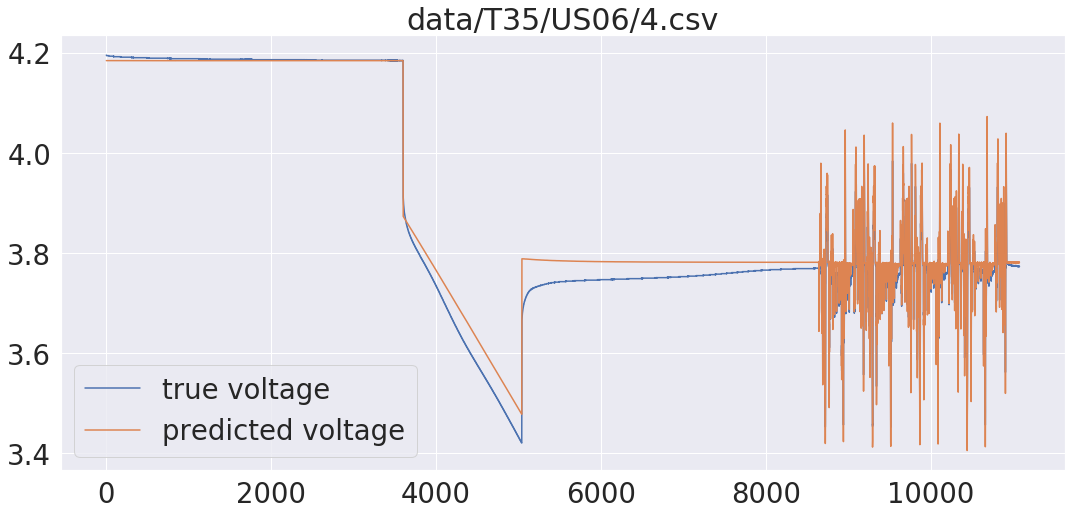

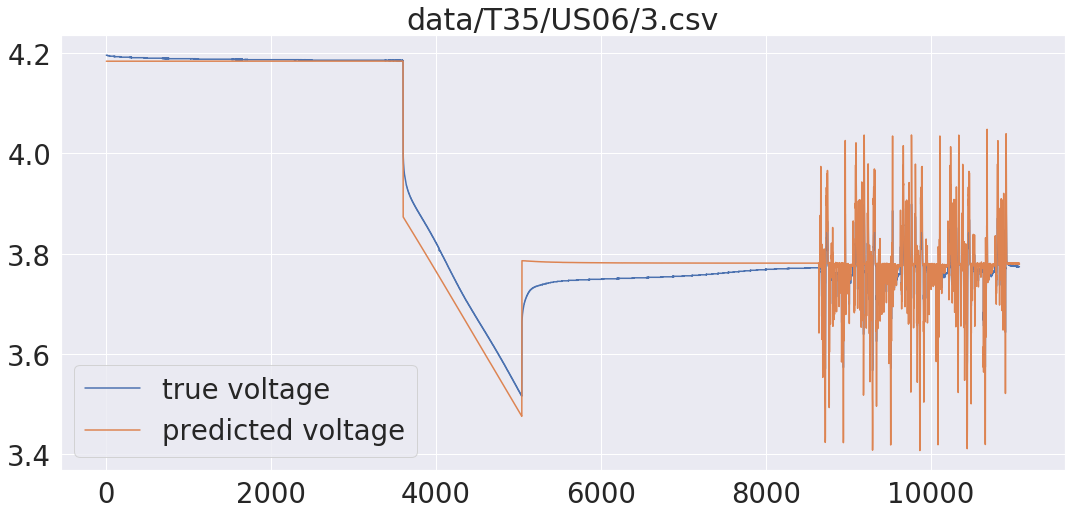

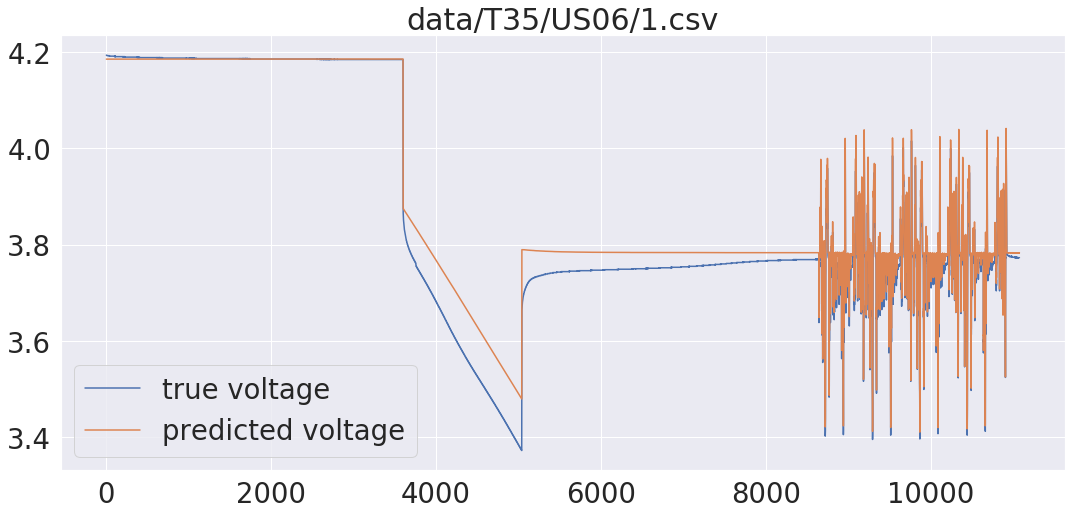

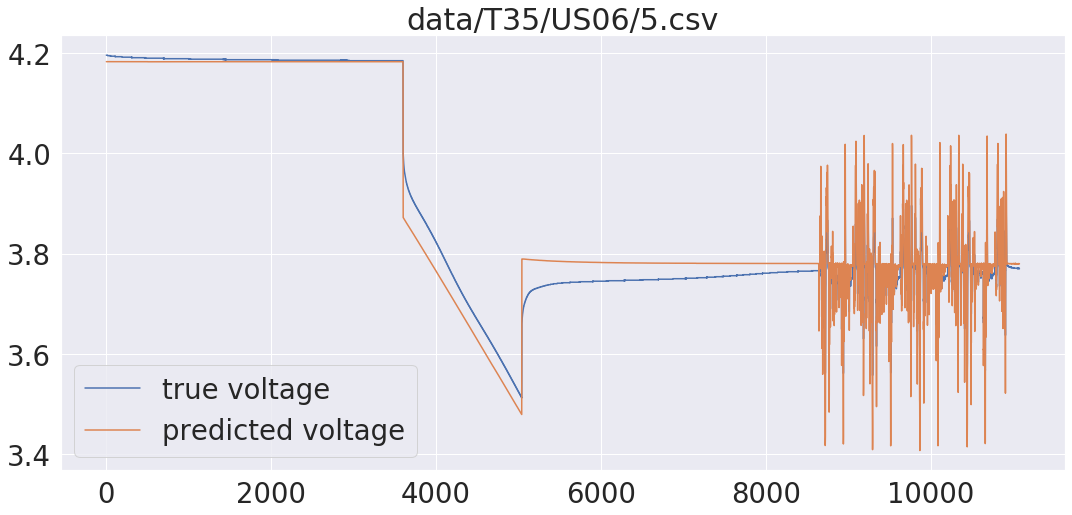

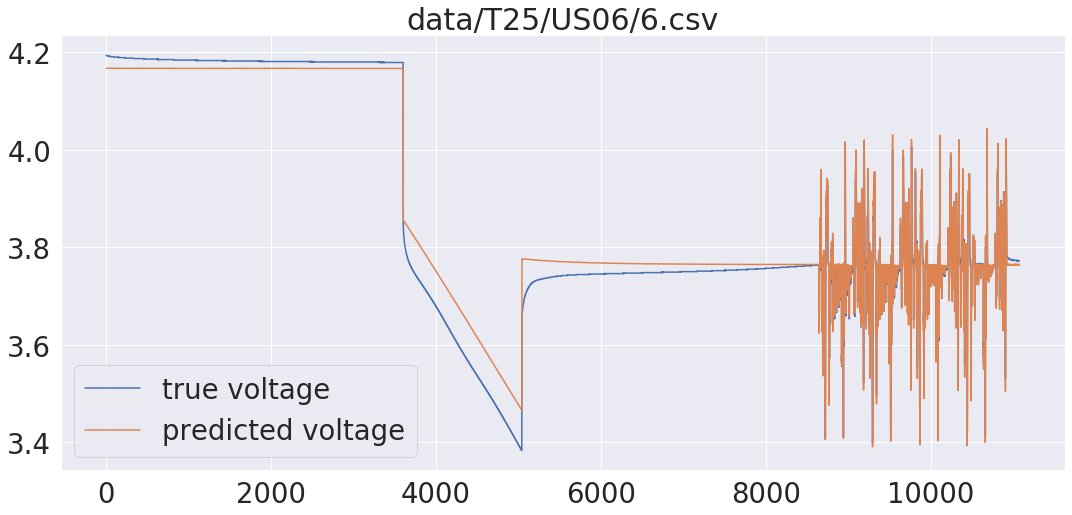

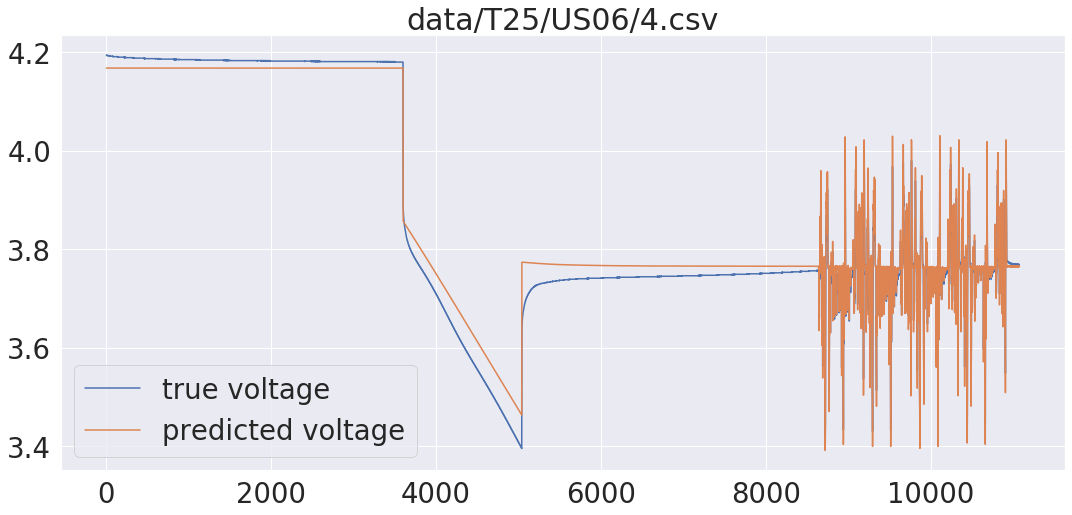

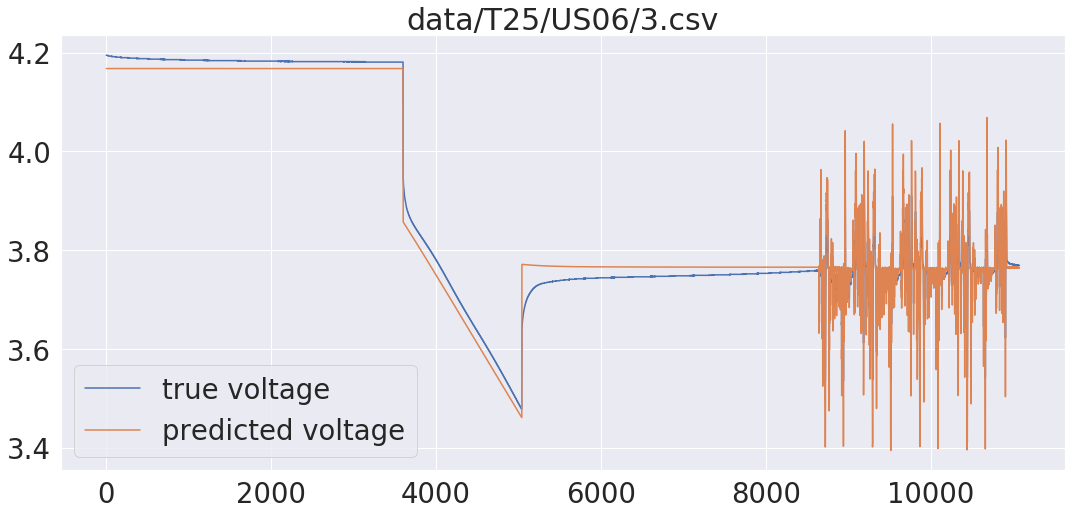

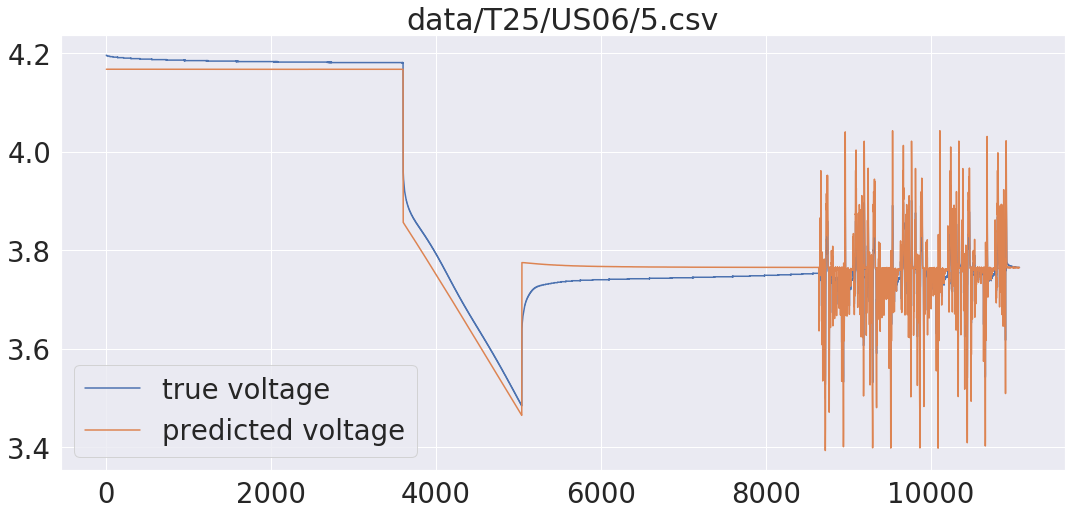

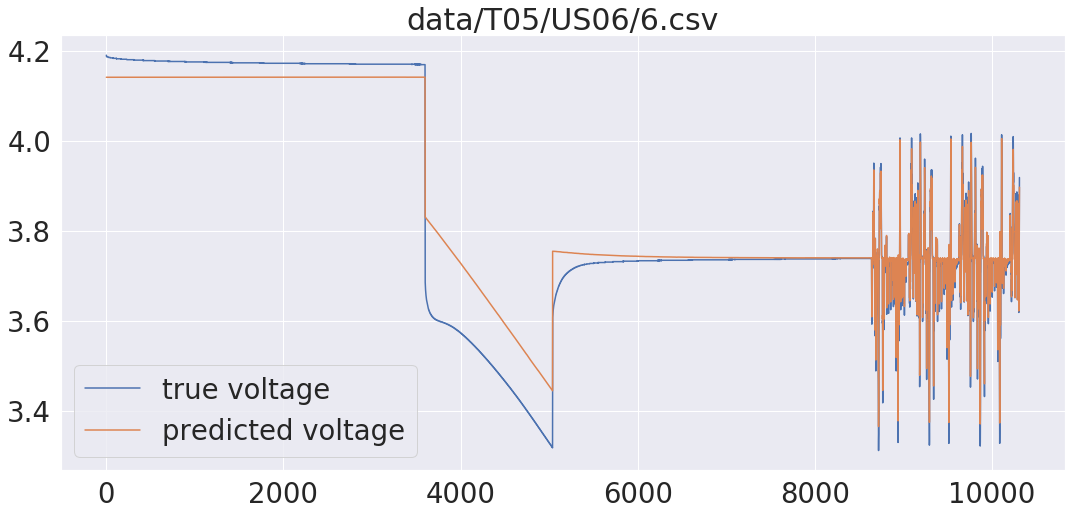

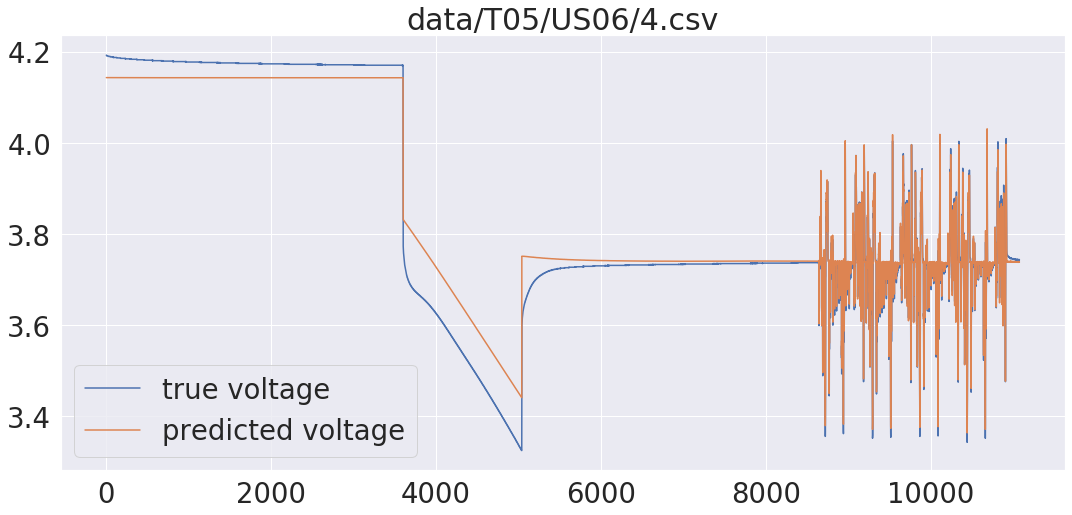

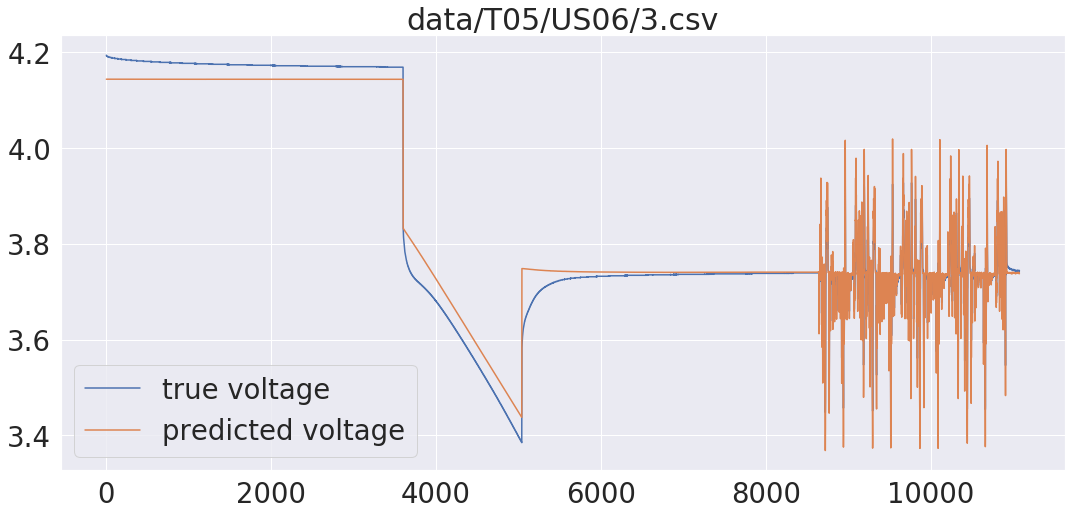

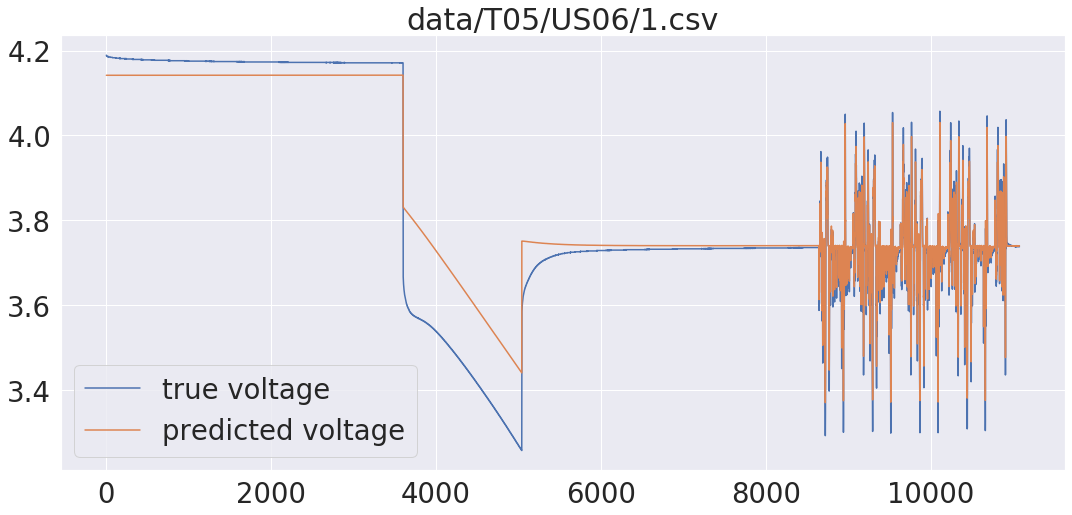

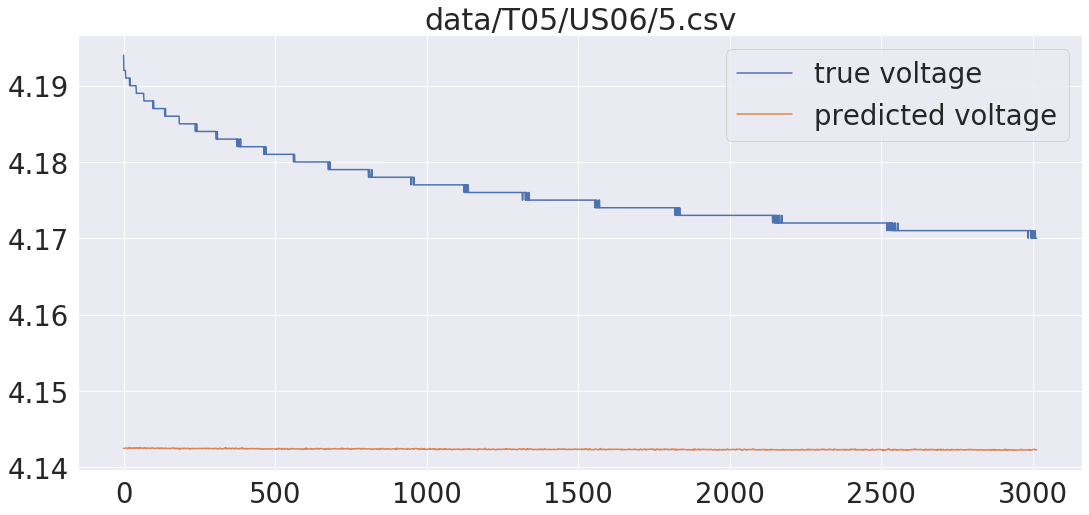

In [195]:
ml_preds(model_reg, X_dev, y_dev, df_costs['reg'])

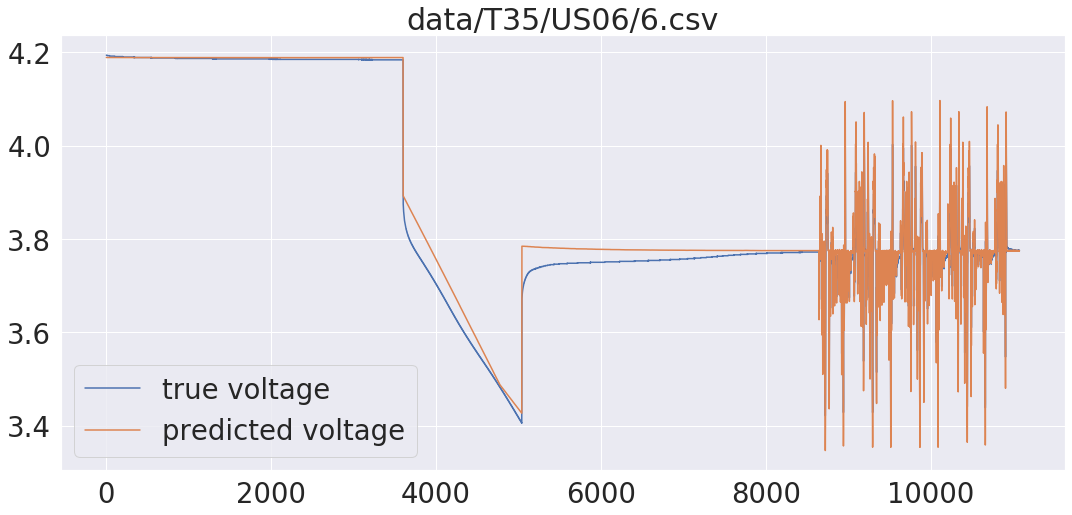

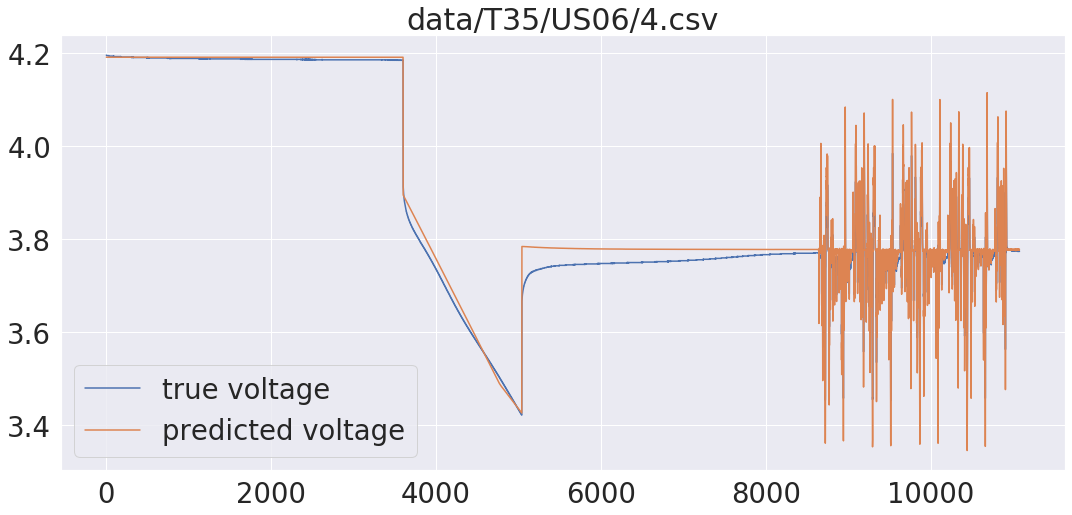

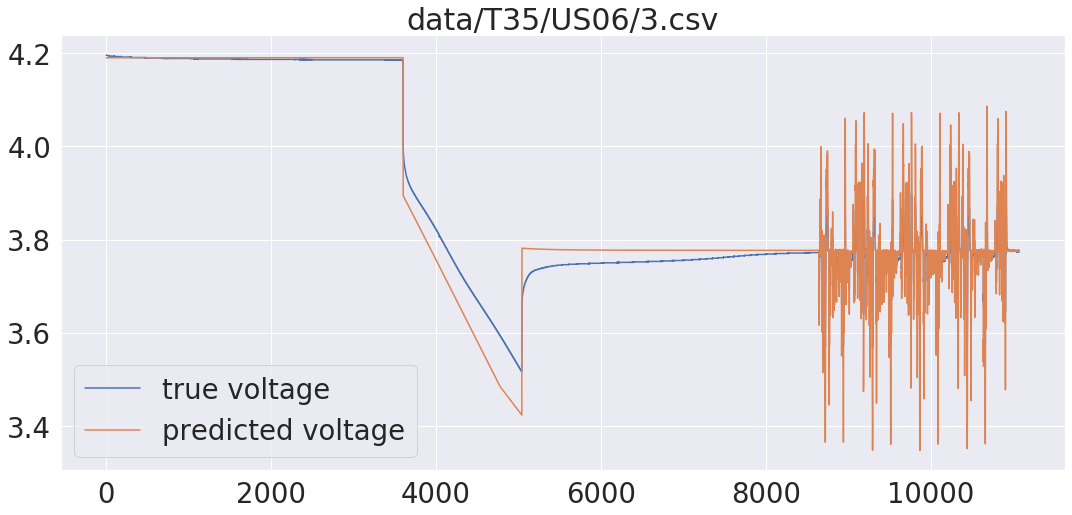

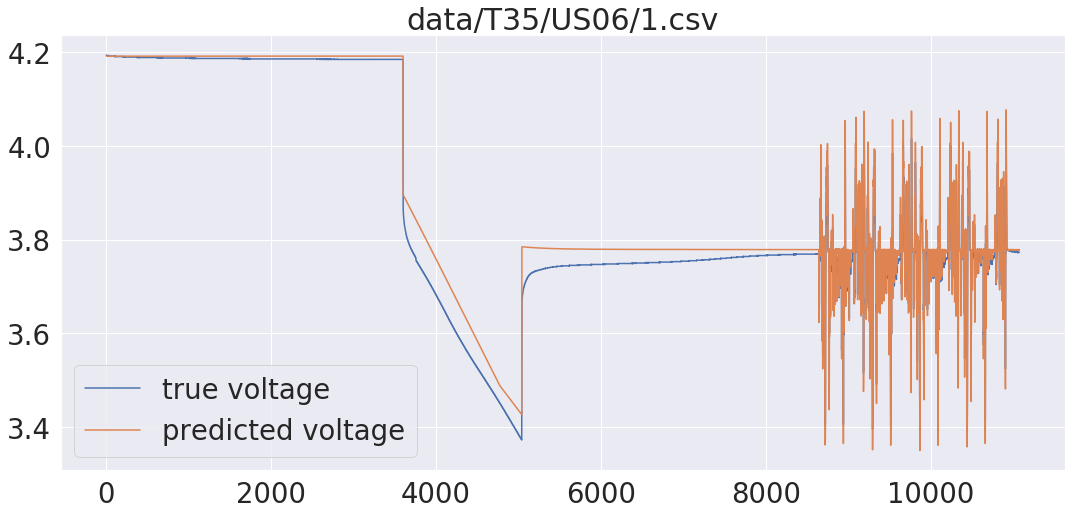

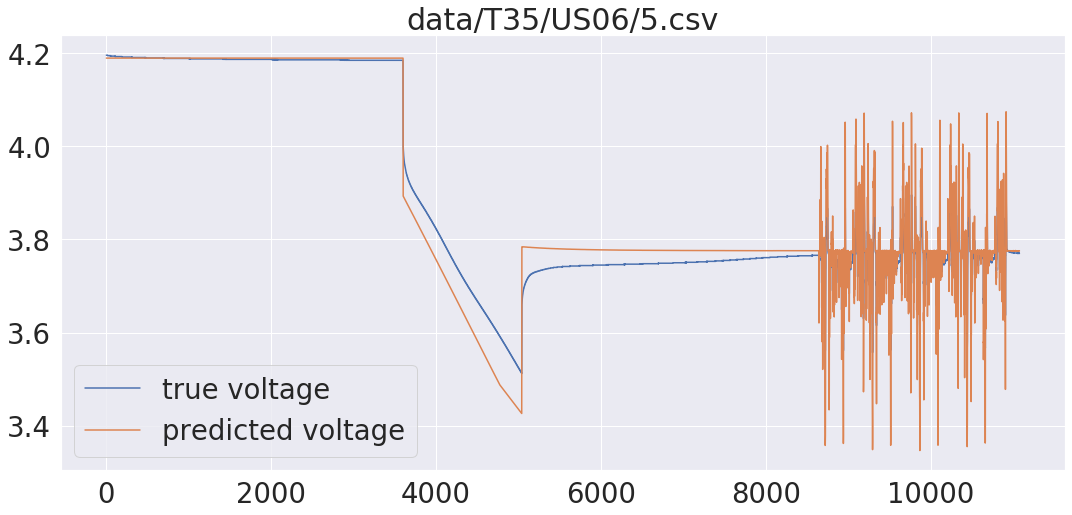

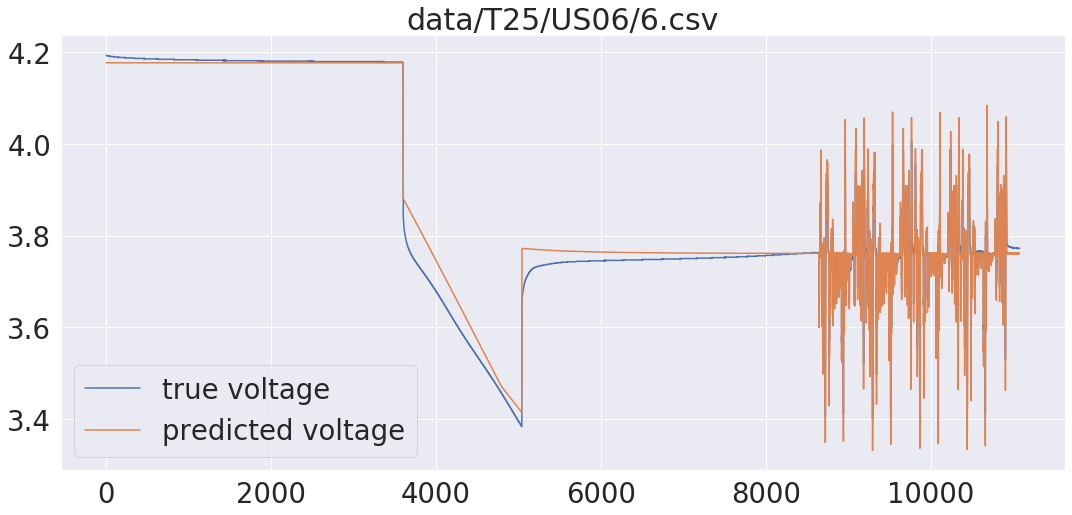

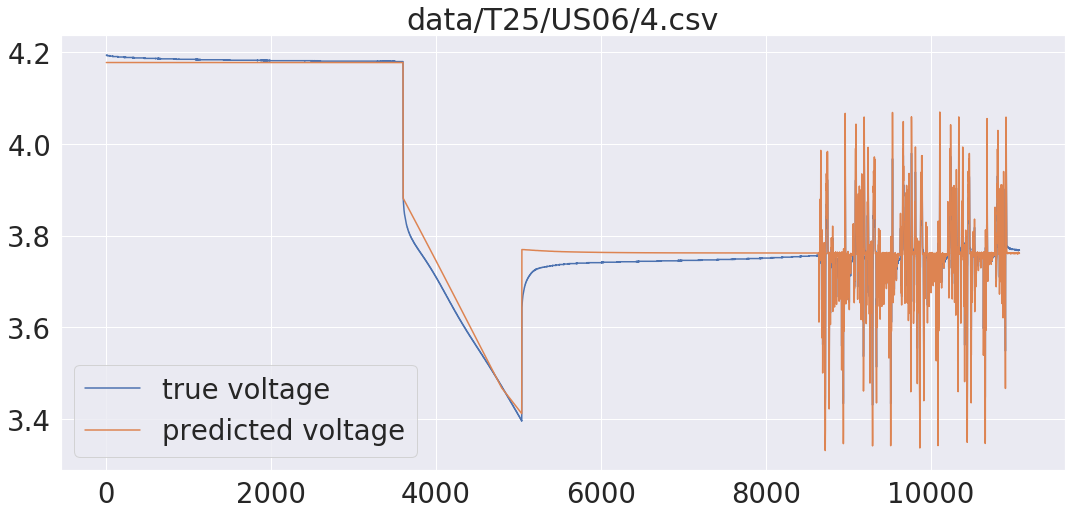

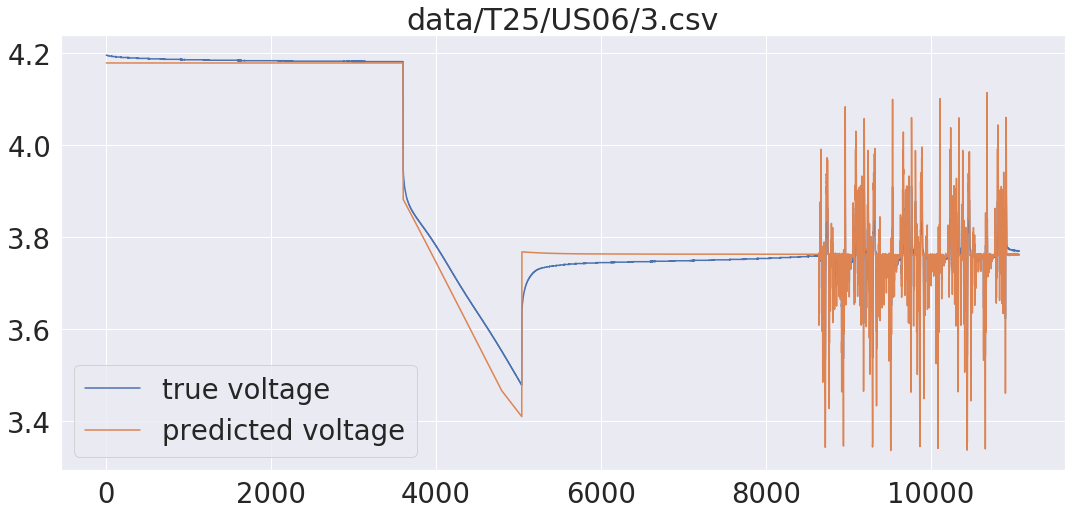

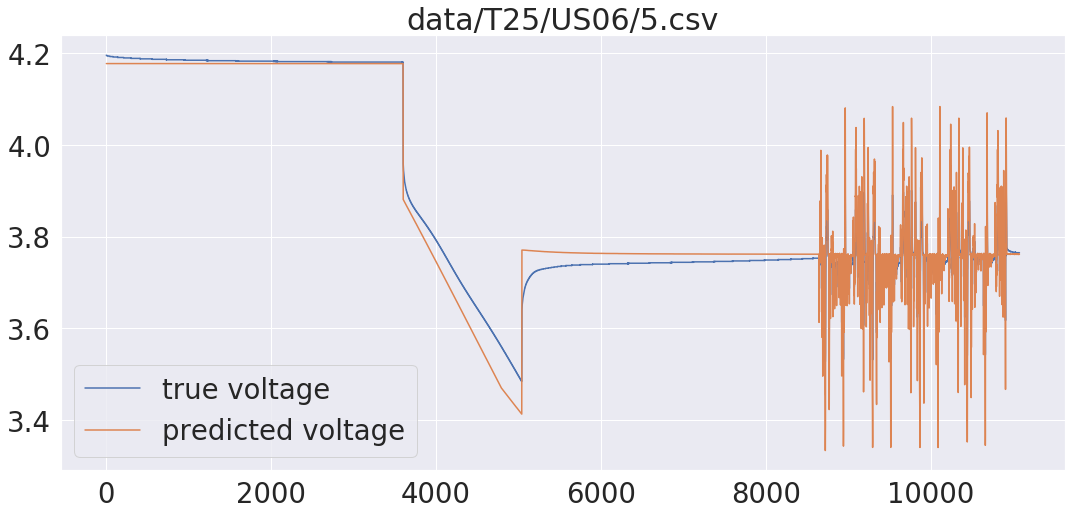

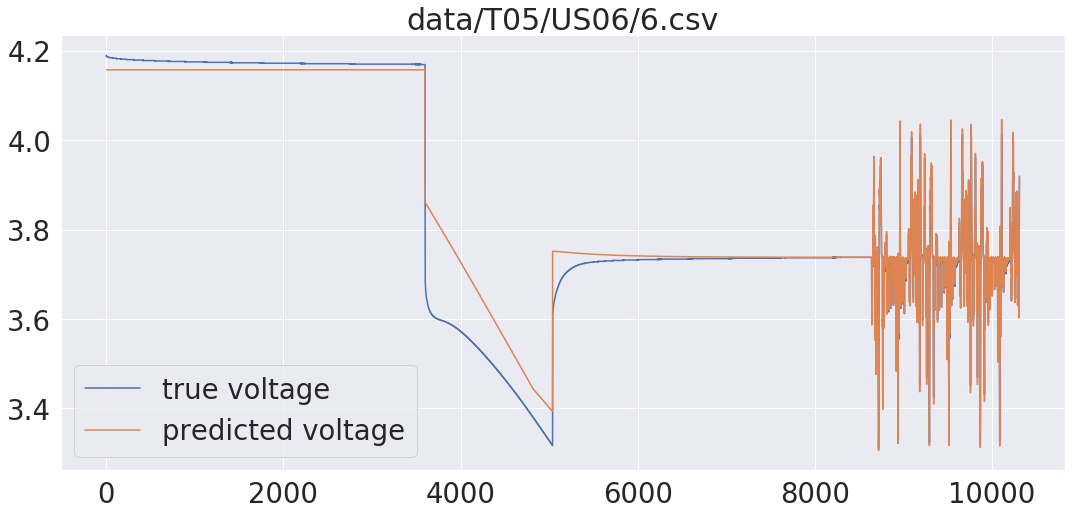

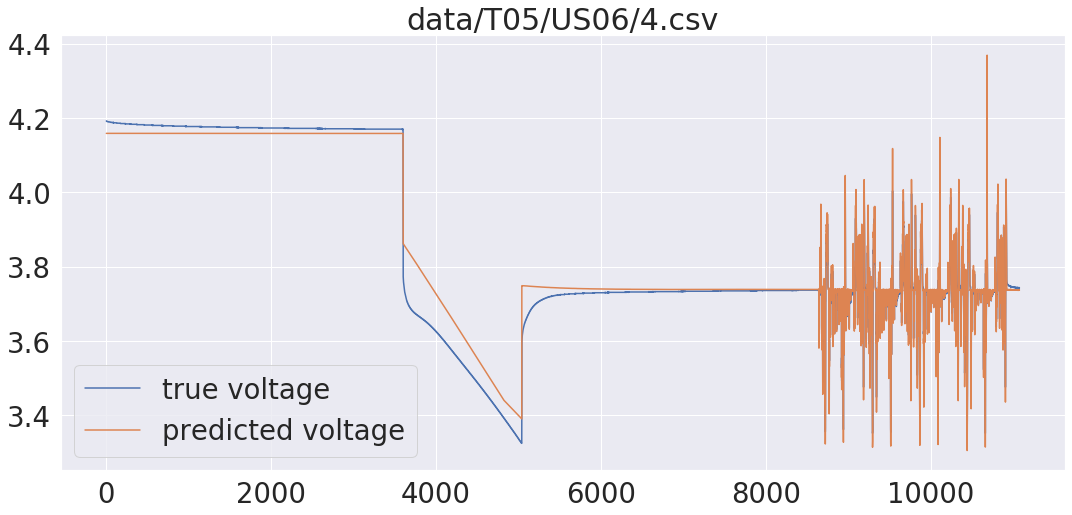

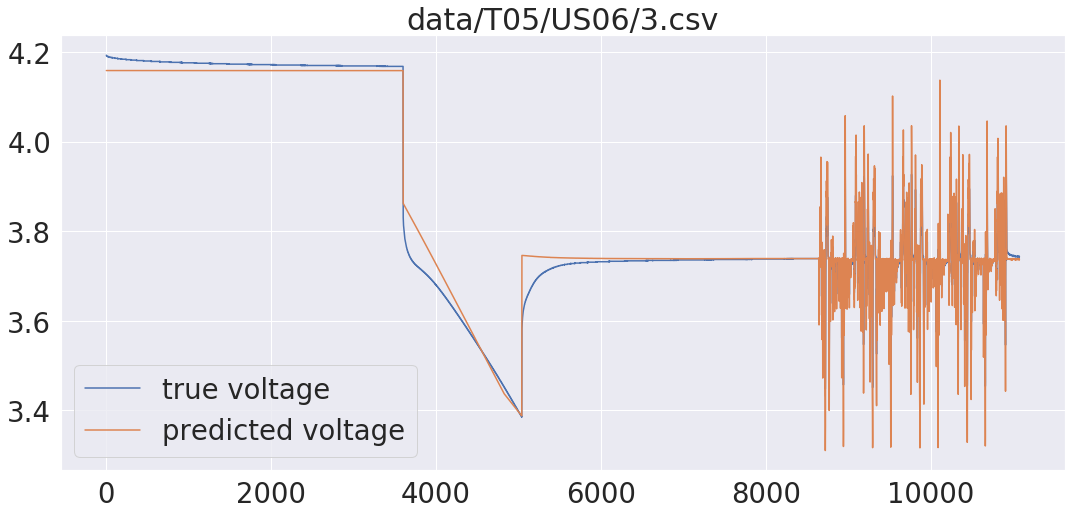

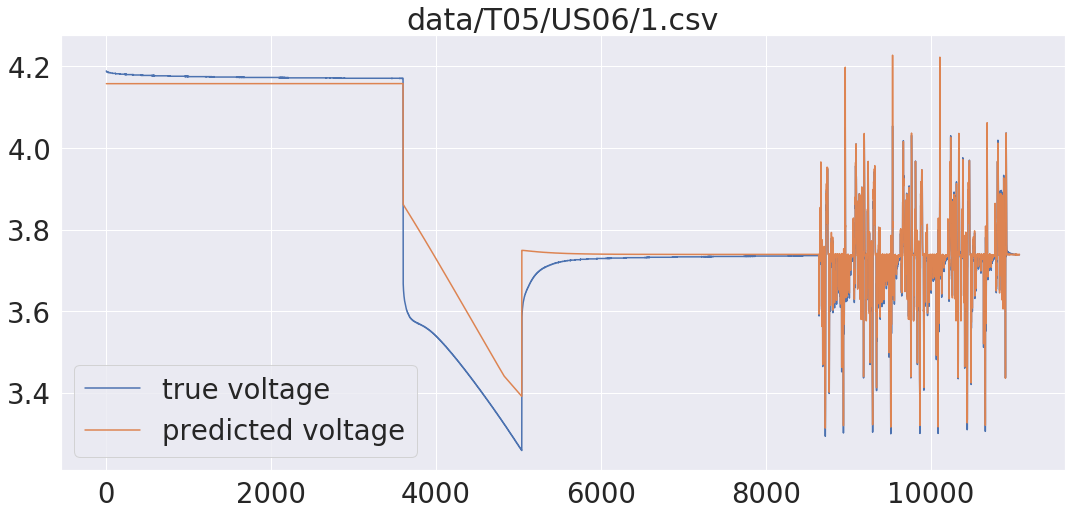

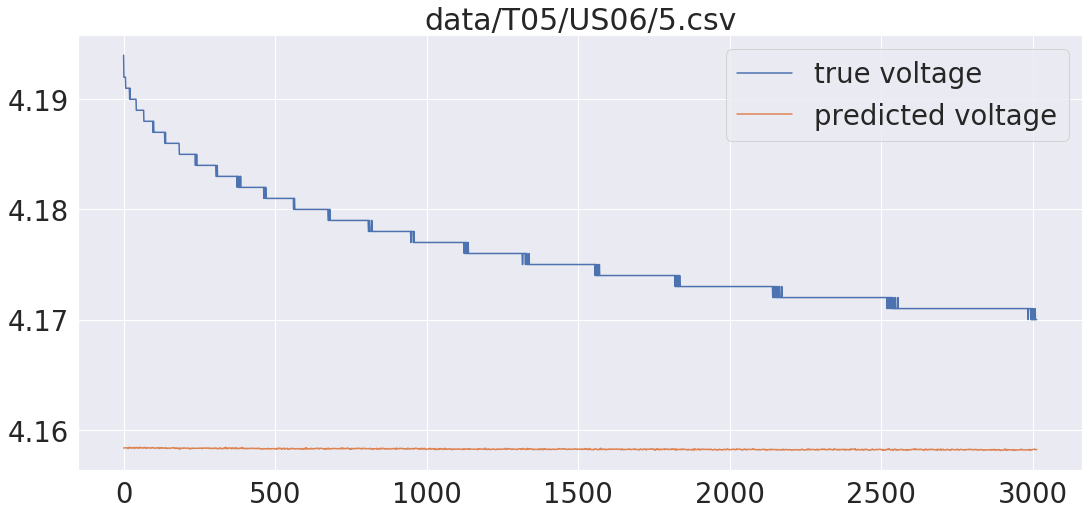

In [196]:
ml_preds(model_nn_relu, X_dev, y_dev, df_costs['nn_relu'])

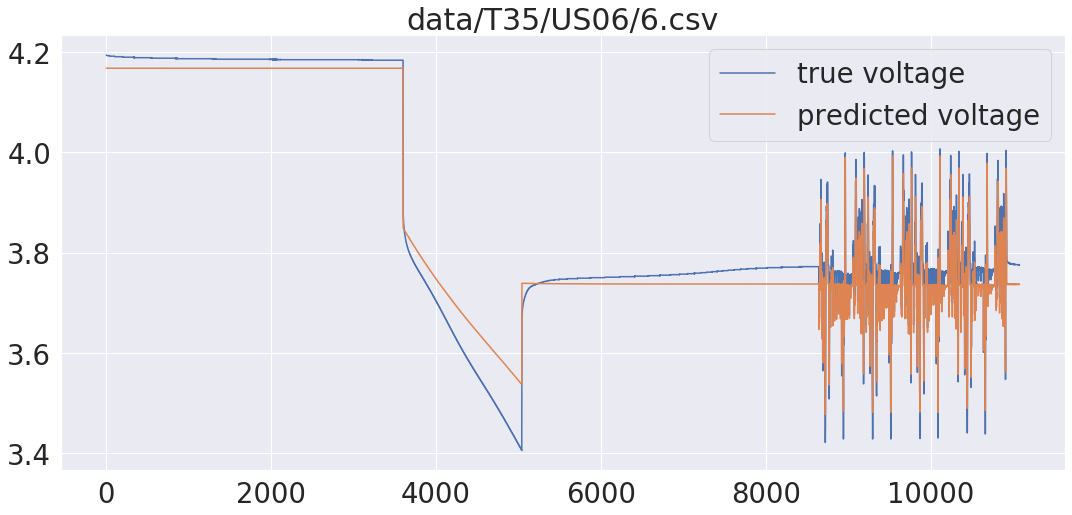

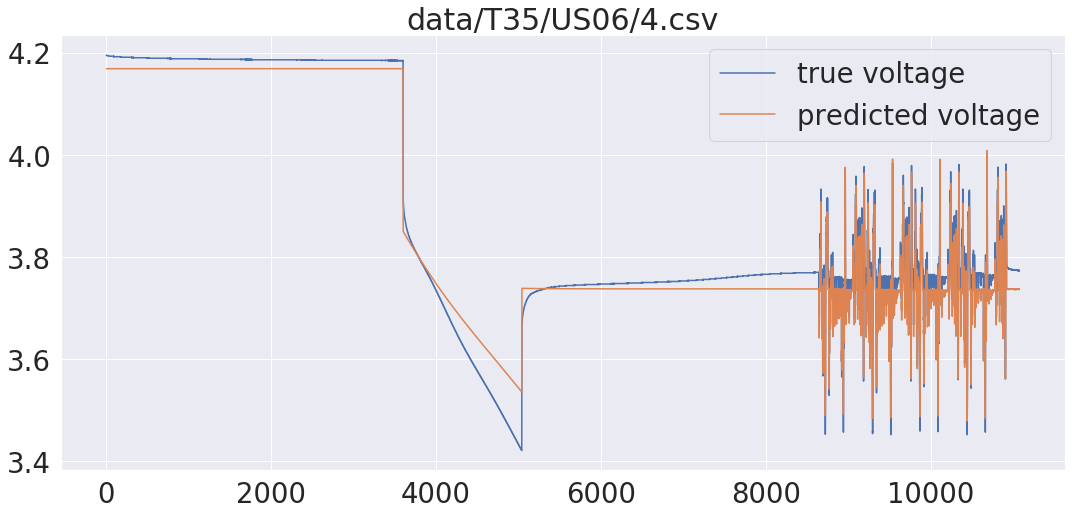

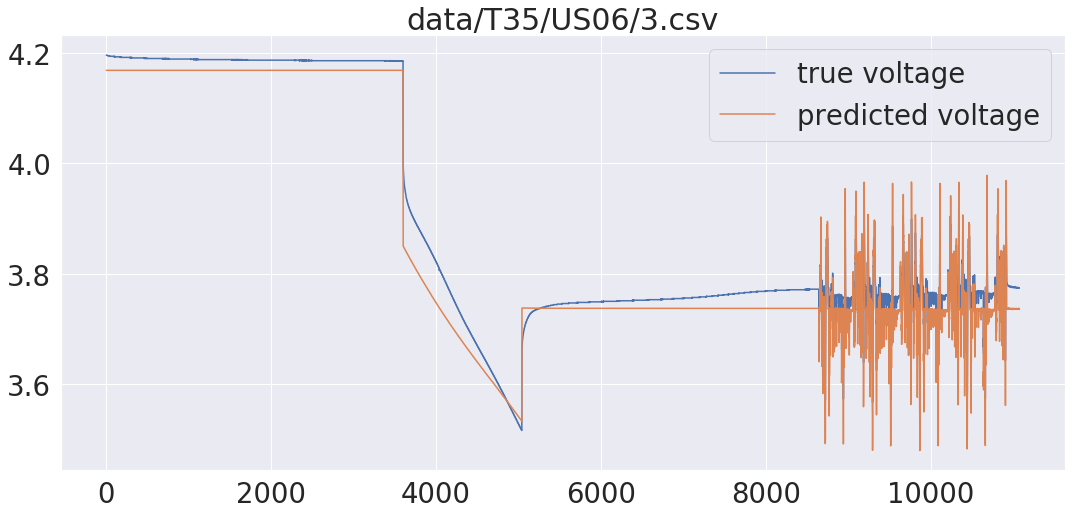

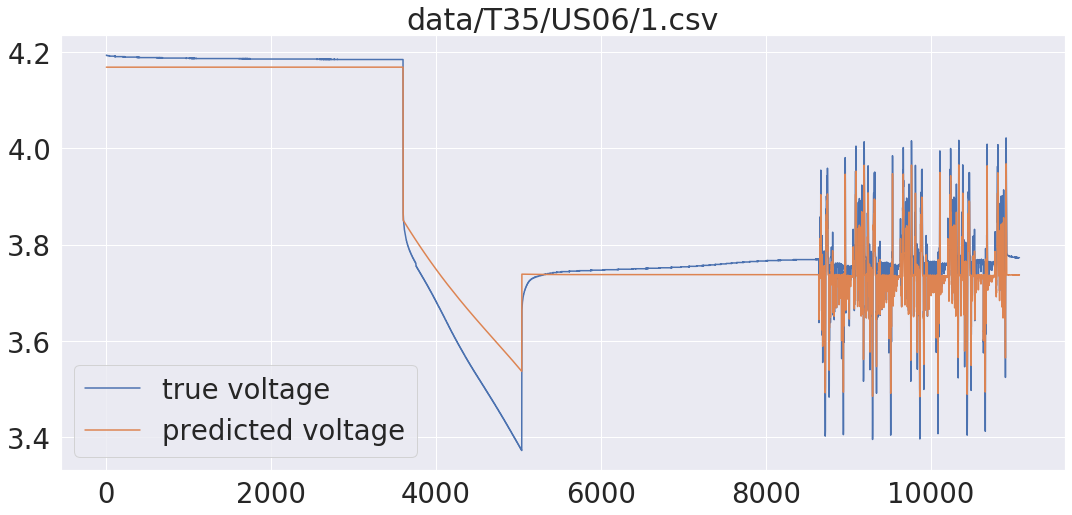

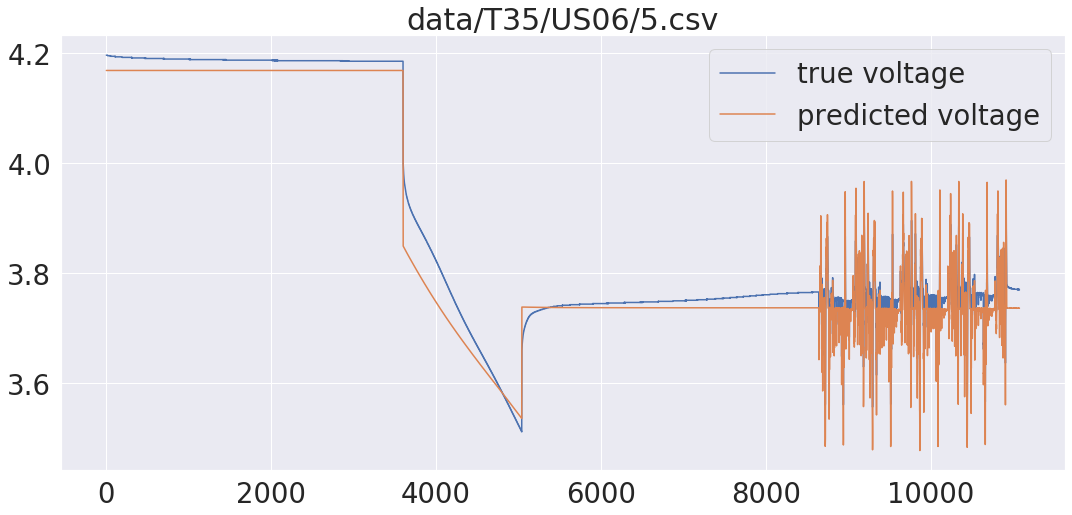

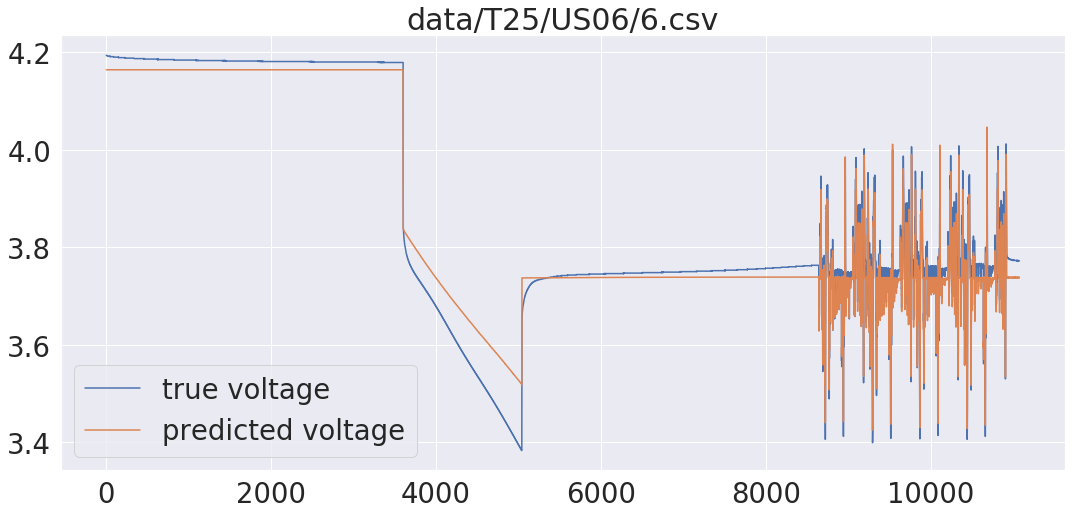

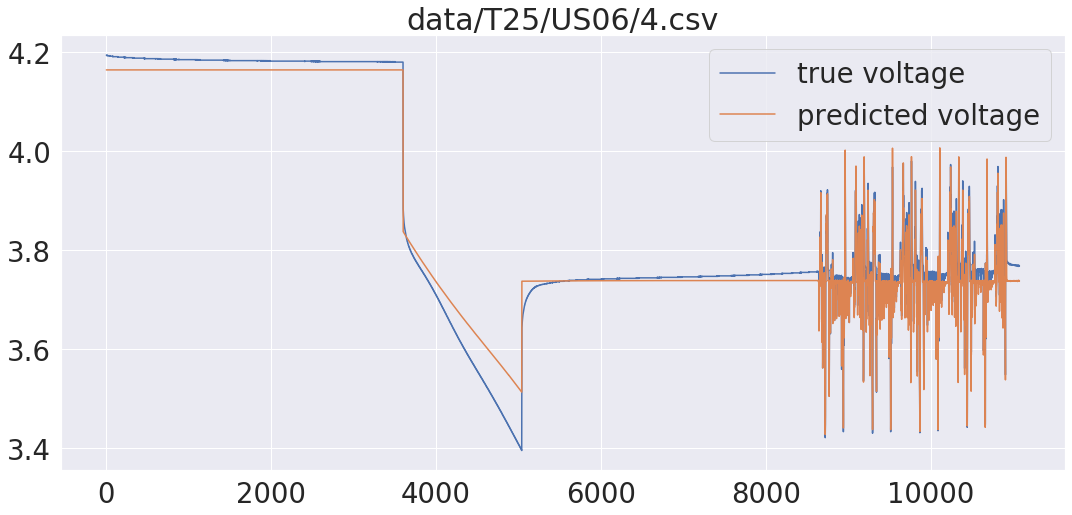

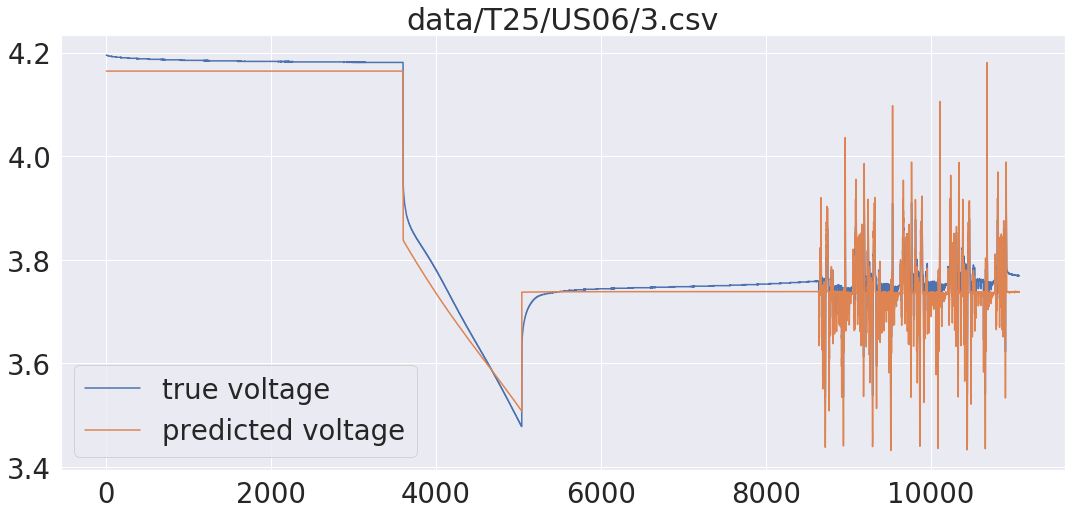

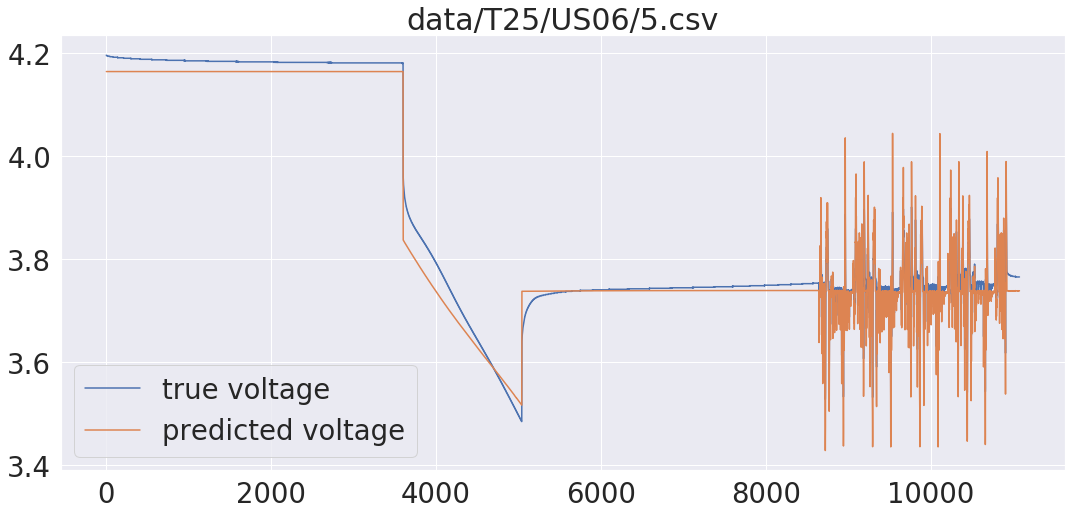

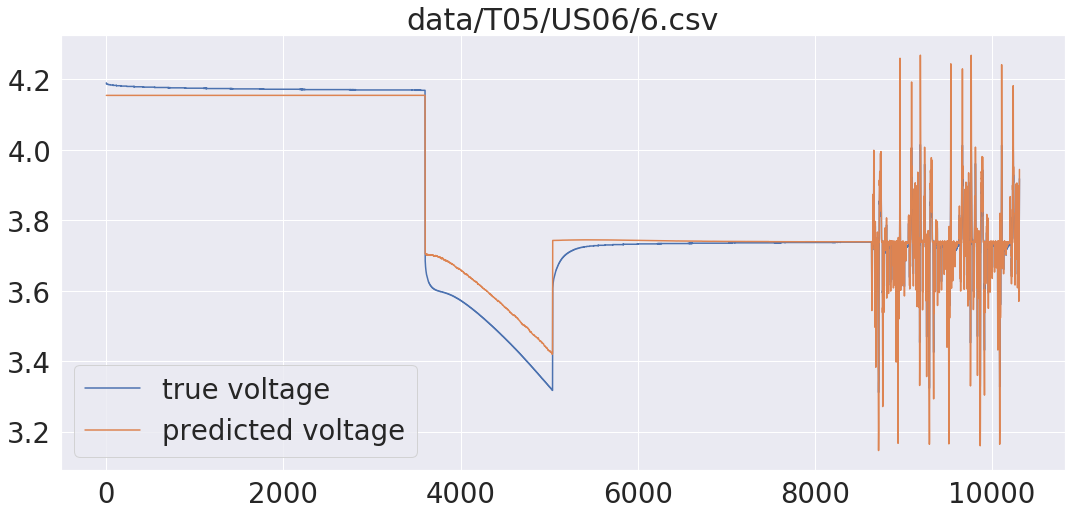

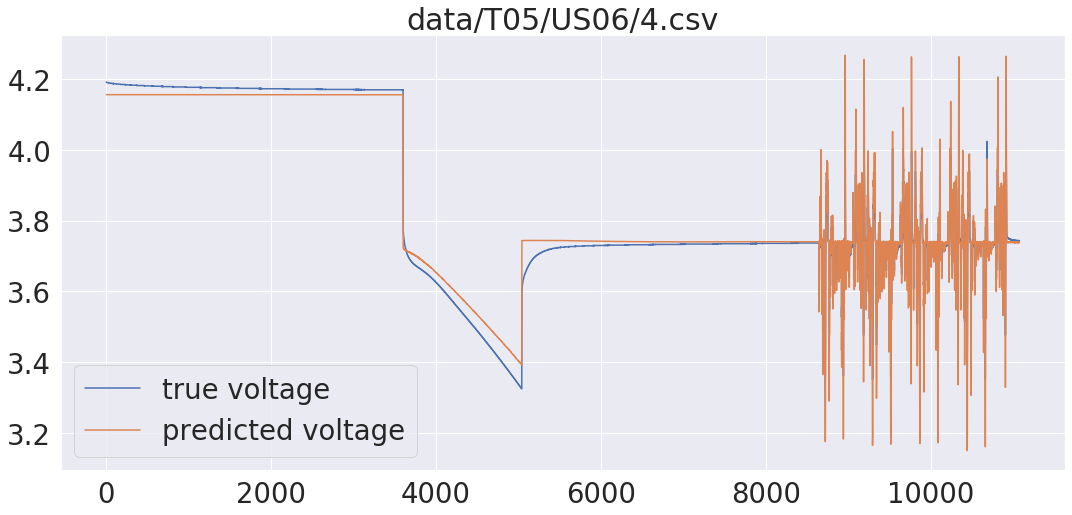

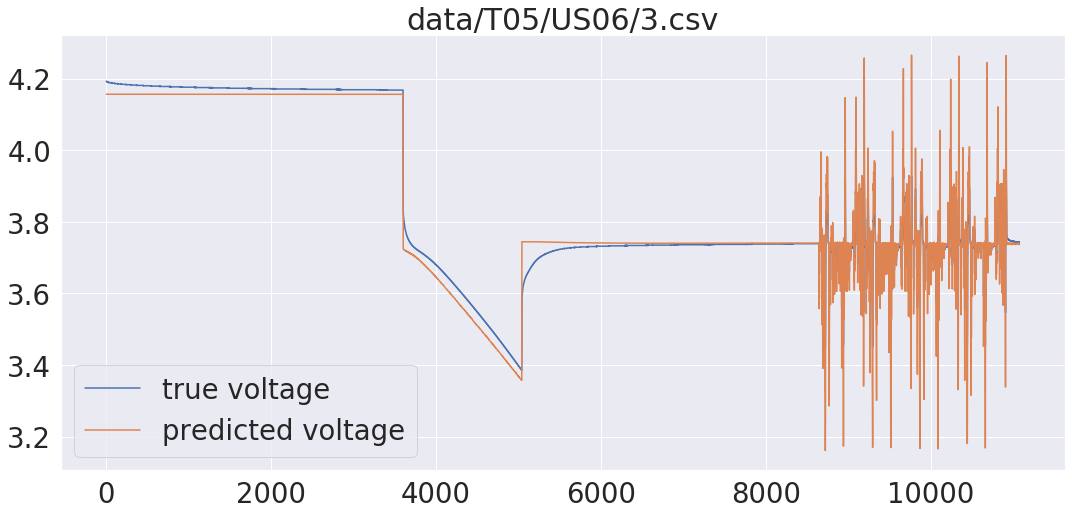

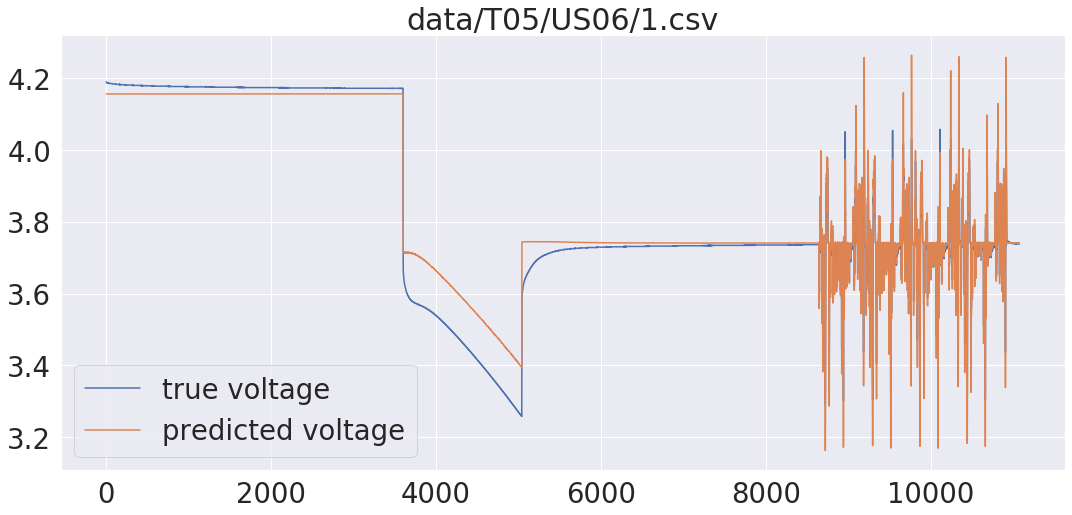

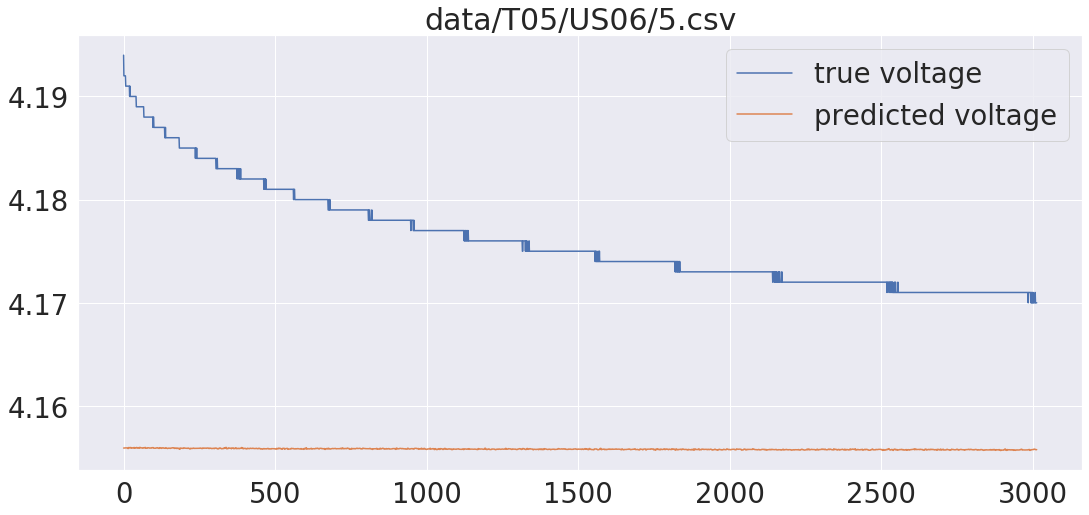

In [197]:
ml_preds(model_nn_tanh, X_dev, y_dev, df_costs['nn_tanh'])

windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data
windowing data


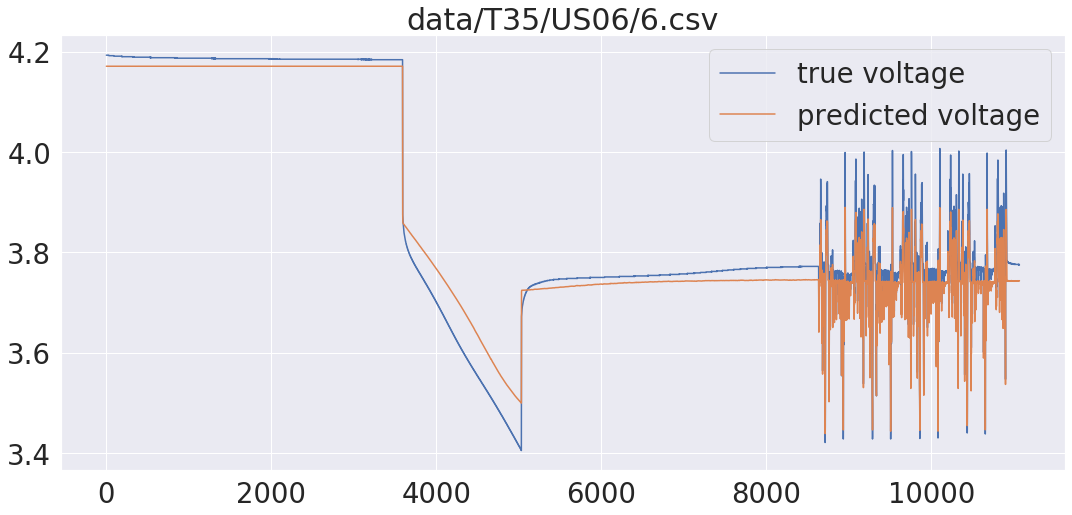

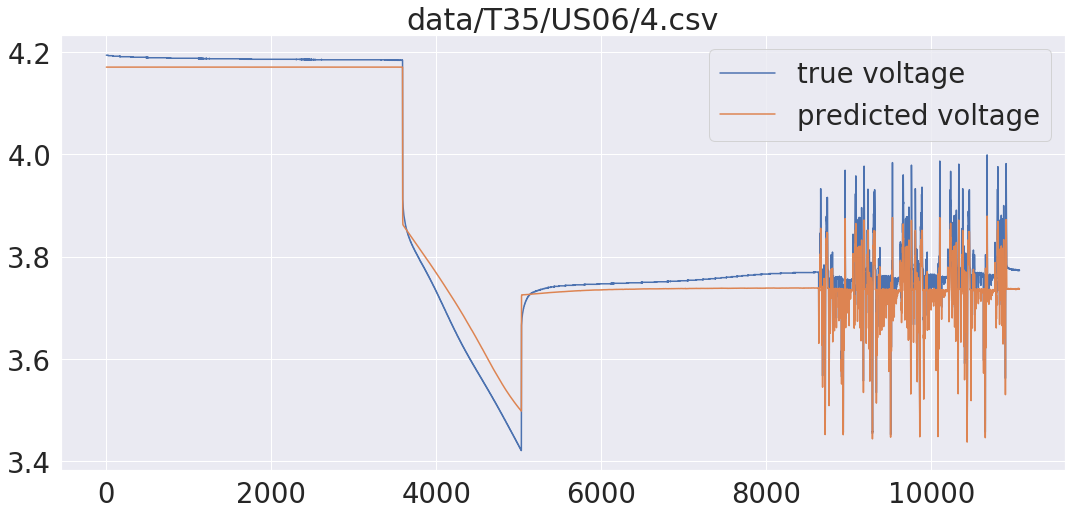

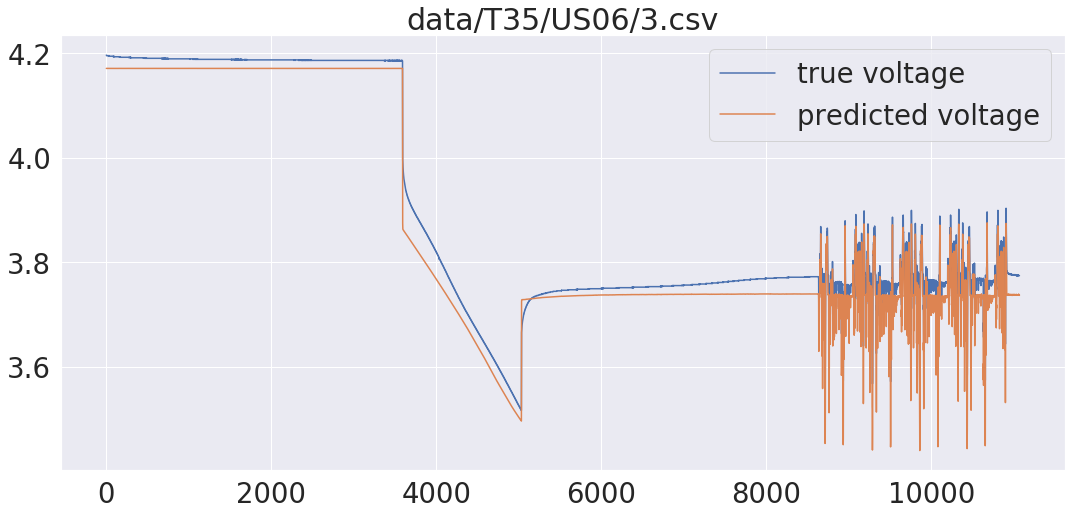

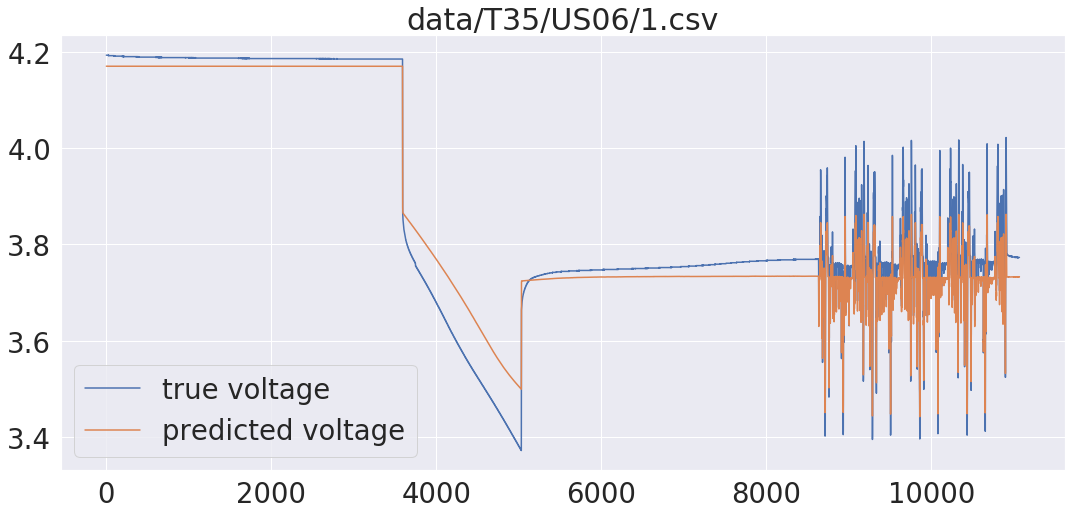

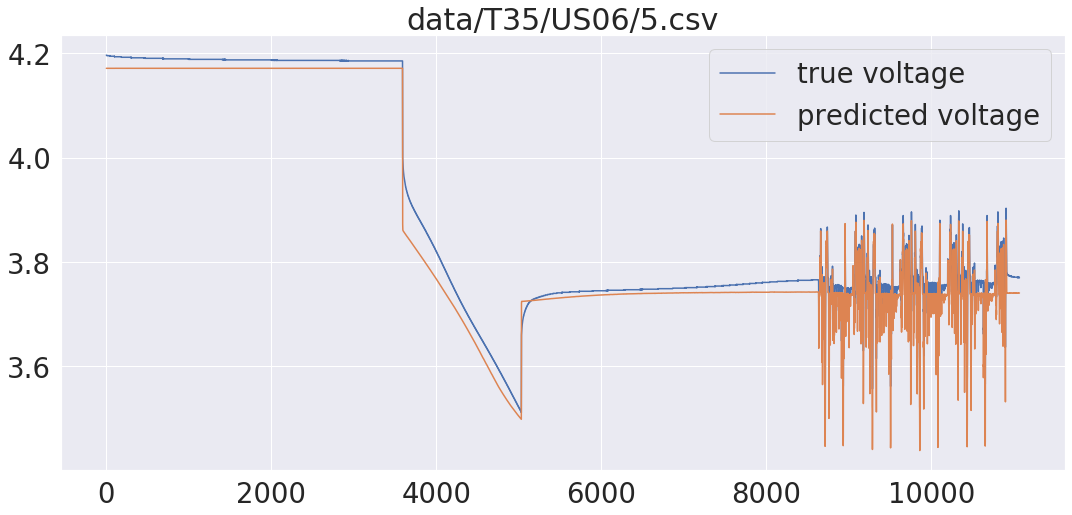

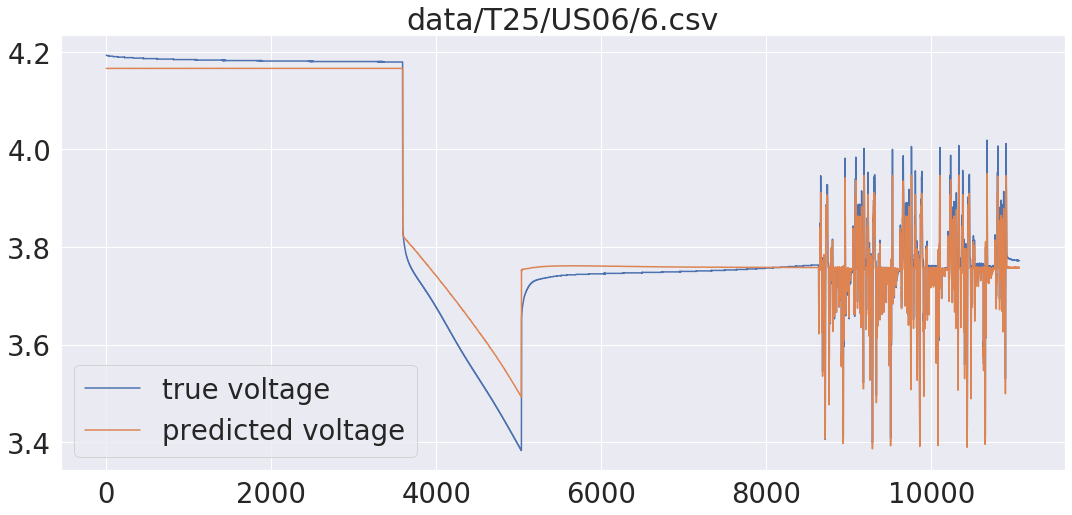

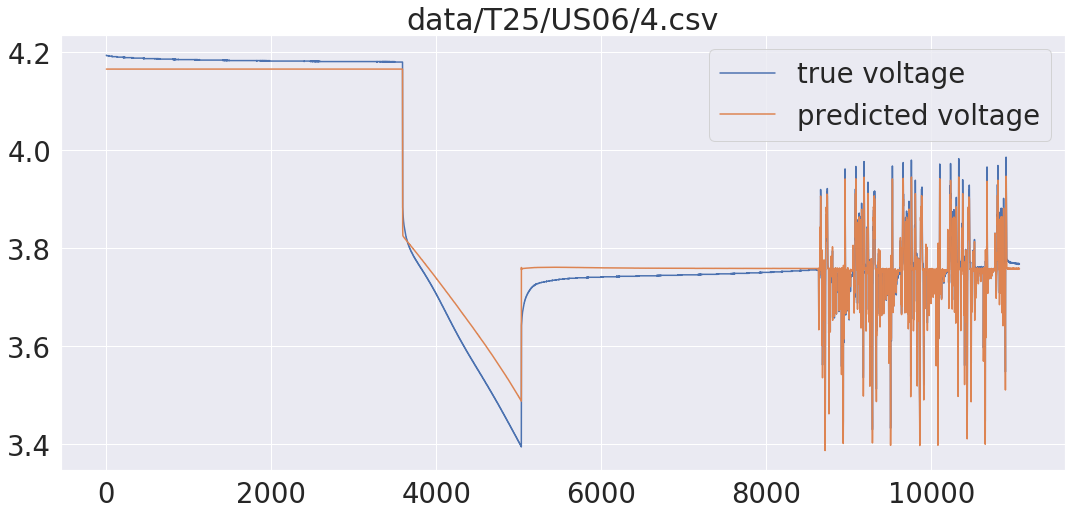

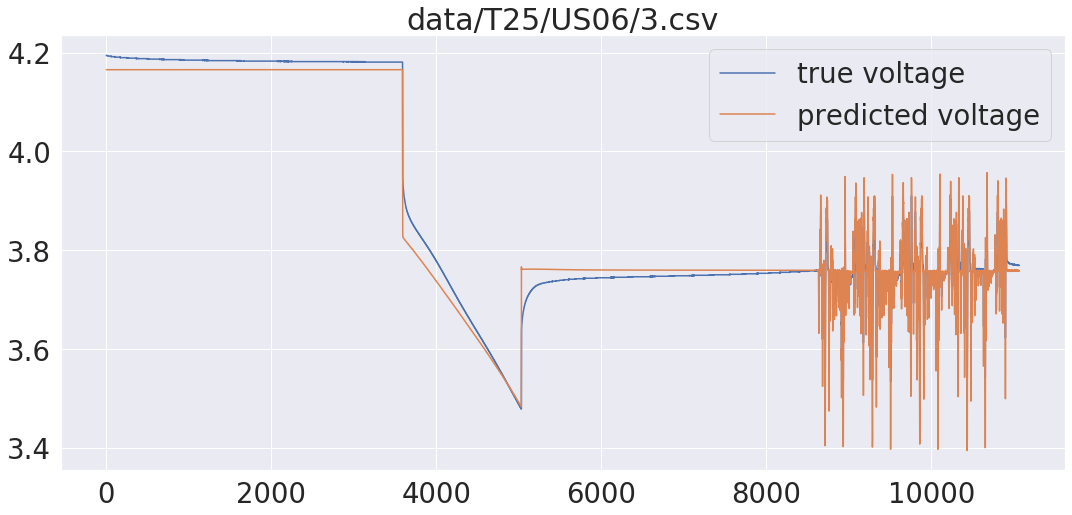

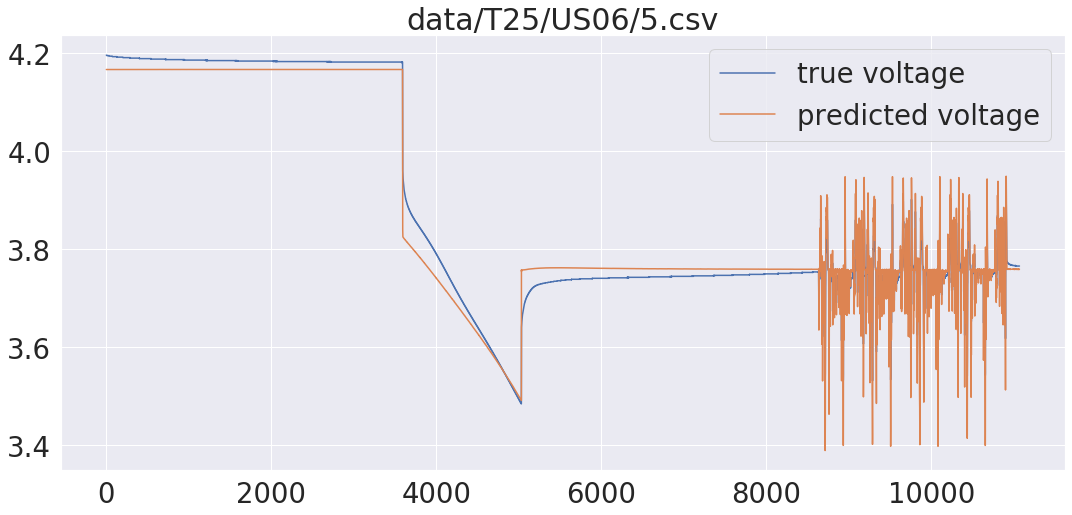

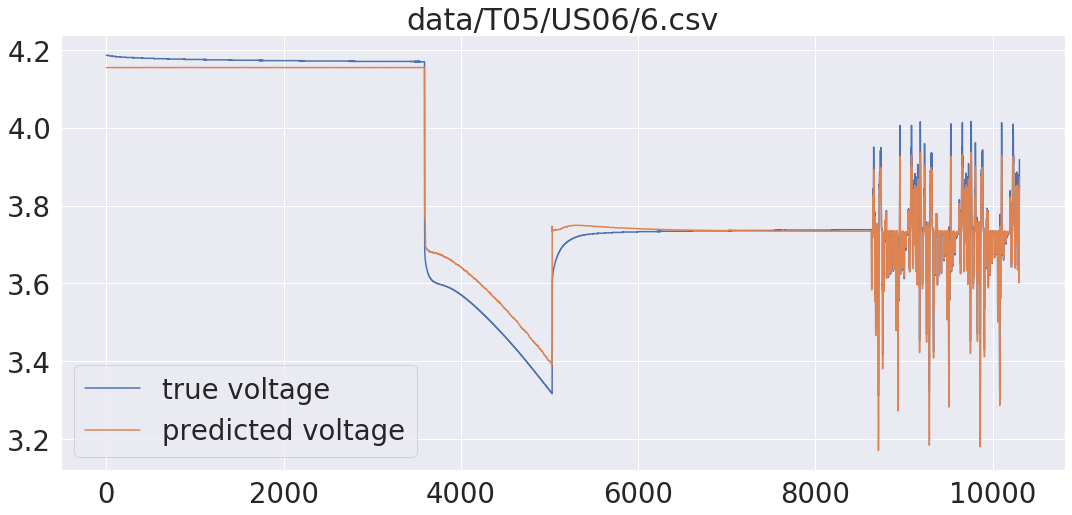

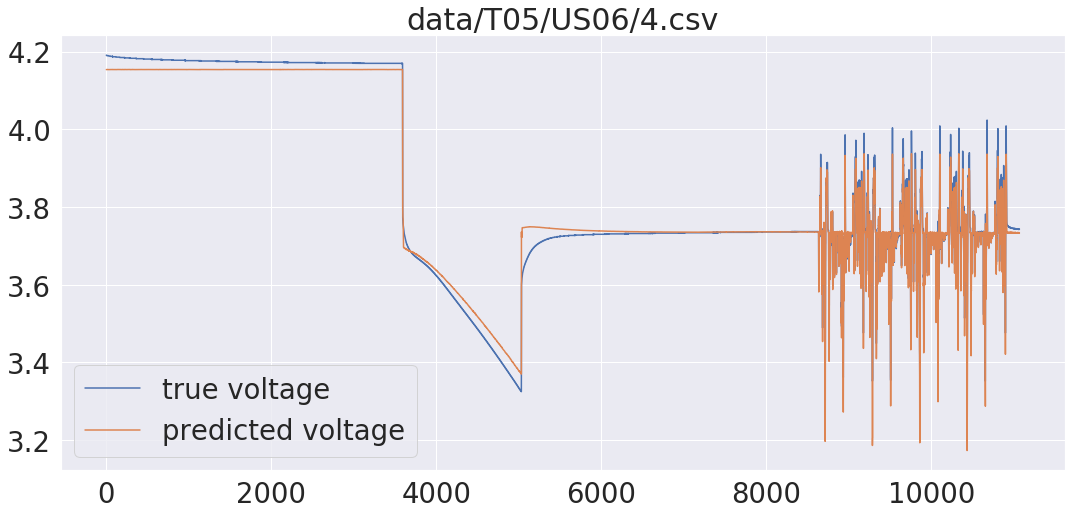

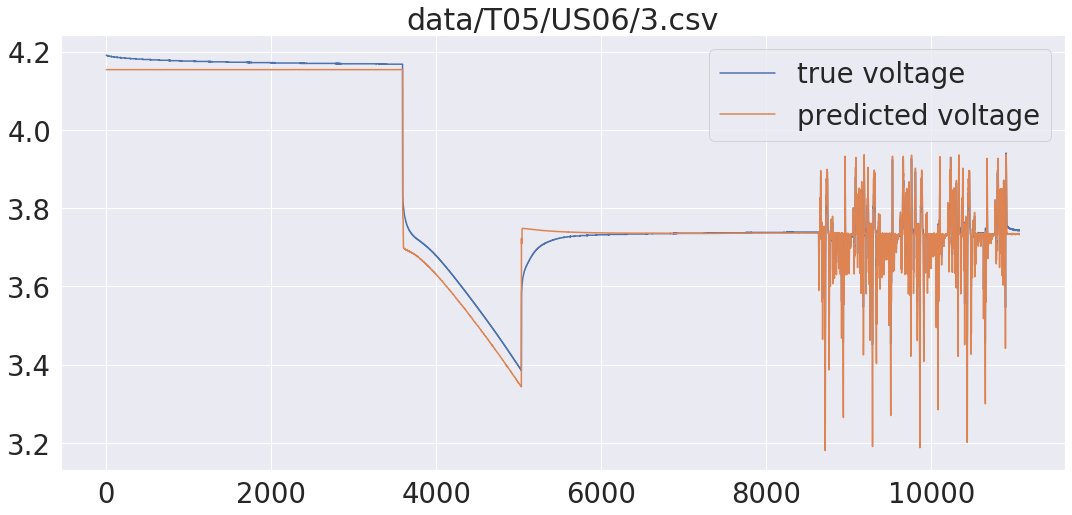

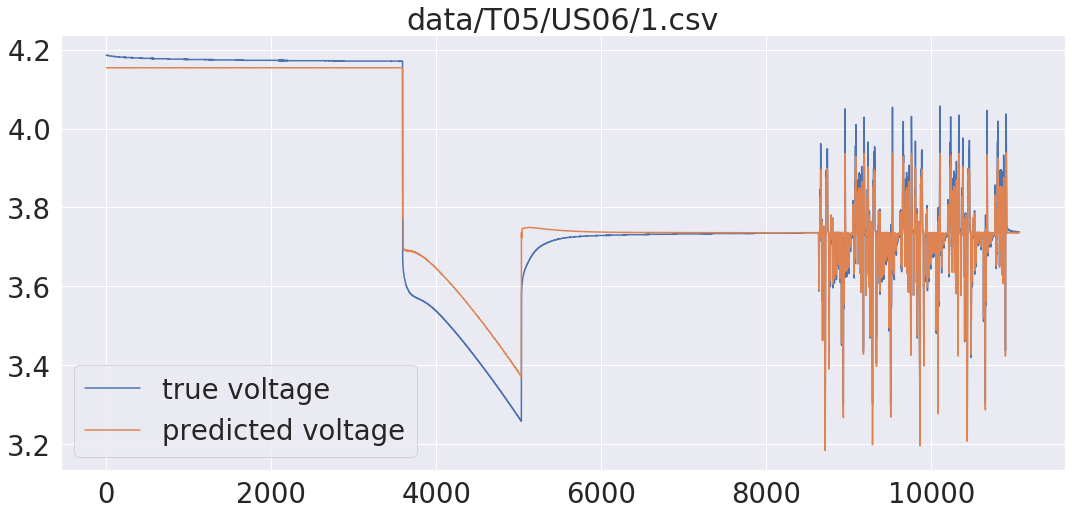

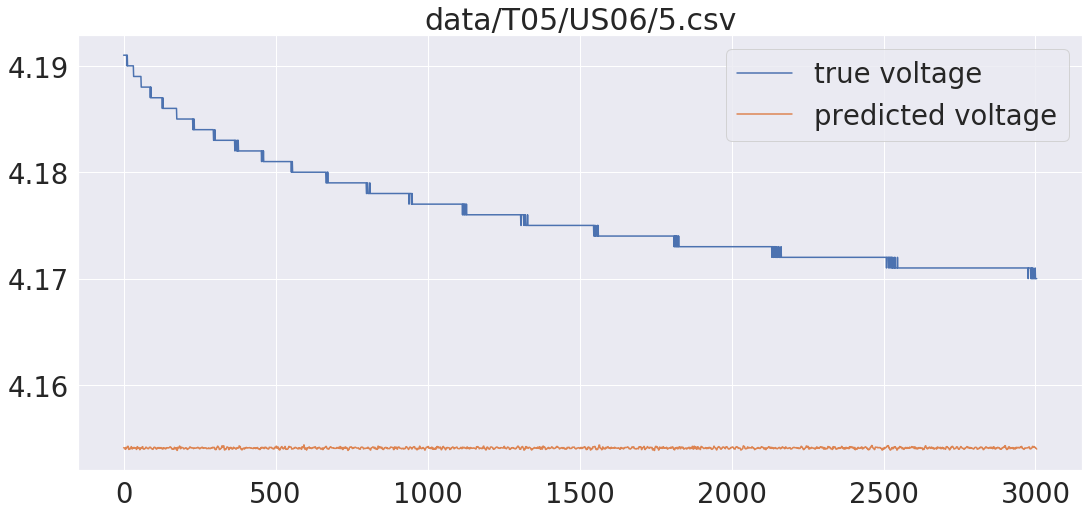

In [198]:
ml_preds(model_lstm, X_dev, y_dev, df_costs['lstm'], isLSTM = True, window_size = lstm_window_size)

# Plot Results

In [199]:
print(df_costs.head())
df_costs.drop(columns=['reg'], inplace=True)
print(df_costs.head())

                         circuit          reg      nn_relu      nn_tanh  \
data/T35/US06/6.csv  0.000909161  0.000909077  0.000547699   0.00134344   
data/T35/US06/4.csv  0.000716645  0.000706418  0.000505788  0.000924078   
data/T35/US06/3.csv   0.00189039   0.00101329   0.00168192  0.000973488   
data/T35/US06/1.csv   0.00109563   0.00160298  0.000939754   0.00194582   
data/T35/US06/5.csv   0.00170515   0.00112268   0.00172294  0.000859826   

                            lstm  
data/T35/US06/6.csv   0.00113757  
data/T35/US06/4.csv  0.000844451  
data/T35/US06/3.csv  0.000836502  
data/T35/US06/1.csv   0.00199517  
data/T35/US06/5.csv  0.000660789  
                         circuit      nn_relu      nn_tanh         lstm
data/T35/US06/6.csv  0.000909161  0.000547699   0.00134344   0.00113757
data/T35/US06/4.csv  0.000716645  0.000505788  0.000924078  0.000844451
data/T35/US06/3.csv   0.00189039   0.00168192  0.000973488  0.000836502
data/T35/US06/1.csv   0.00109563  0.000939754   0.0

In [200]:
df_costs_new = df_costs.copy()

df_costs_new = df_costs_new.rename(index = lambda s: s.split('/')[1] + '')

idxList = []
for idx in df_costs_new.index:
    idxList.append(idx)

print(df_costs_new)

         circuit      nn_relu      nn_tanh         lstm
T35  0.000909161  0.000547699   0.00134344   0.00113757
T35  0.000716645  0.000505788  0.000924078  0.000844451
T35   0.00189039   0.00168192  0.000973488  0.000836502
T35   0.00109563  0.000939754   0.00194582   0.00199517
T35   0.00170515   0.00172294  0.000859826  0.000660789
T25  0.000903798  0.000613345   0.00133772   0.00114383
T25  0.000506233  0.000443967  0.000845458  0.000762141
T25  0.000813832   0.00107562  0.000558871  0.000546351
T25  0.000844468   0.00124292   0.00056386  0.000641056
T05   0.00311074   0.00274438   0.00158395   0.00102967
T05   0.00164432   0.00133752  0.000833657  0.000484076
T05  0.000411912  0.000715896   0.00119092   0.00082643
T05   0.00478802   0.00409395   0.00257709   0.00196802
T05   3.9629e-05   0.00034345  0.000436221  0.000507556


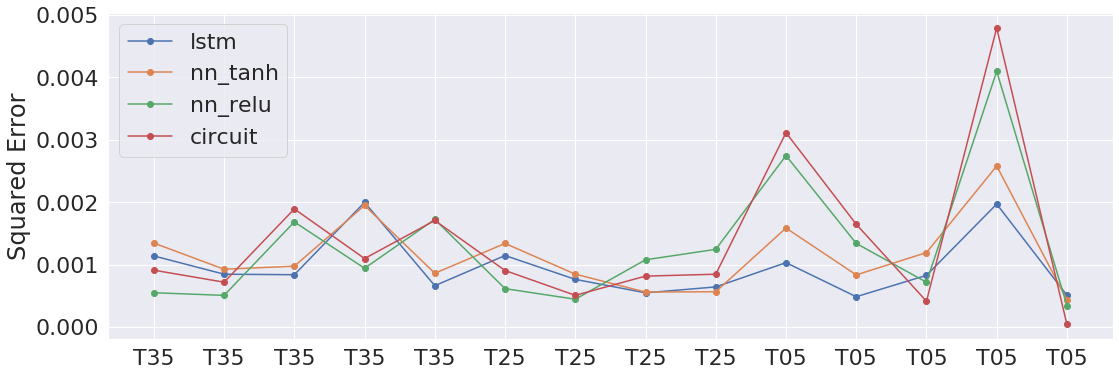

In [222]:
fig, ax = plt.subplots(figsize=(18, 6)) 
ax.plot(df_costs, '-o')
ax.set_xticklabels(idxList)
plt.ylabel('Squared Error');
plt.legend(df_costs.columns);

# plt.plot(df_costs.index, df_costs_new, '-o'); 
# plt.ylabel('RMS Voltage Error (V^2)');
# plt.xlabel('test run label');
# plt.legend(df_costs.columns)

In [202]:
print(df_costs)

                         circuit      nn_relu      nn_tanh         lstm
data/T35/US06/6.csv  0.000909161  0.000547699   0.00134344   0.00113757
data/T35/US06/4.csv  0.000716645  0.000505788  0.000924078  0.000844451
data/T35/US06/3.csv   0.00189039   0.00168192  0.000973488  0.000836502
data/T35/US06/1.csv   0.00109563  0.000939754   0.00194582   0.00199517
data/T35/US06/5.csv   0.00170515   0.00172294  0.000859826  0.000660789
data/T25/US06/6.csv  0.000903798  0.000613345   0.00133772   0.00114383
data/T25/US06/4.csv  0.000506233  0.000443967  0.000845458  0.000762141
data/T25/US06/3.csv  0.000813832   0.00107562  0.000558871  0.000546351
data/T25/US06/5.csv  0.000844468   0.00124292   0.00056386  0.000641056
data/T05/US06/6.csv   0.00311074   0.00274438   0.00158395   0.00102967
data/T05/US06/4.csv   0.00164432   0.00133752  0.000833657  0.000484076
data/T05/US06/3.csv  0.000411912  0.000715896   0.00119092   0.00082643
data/T05/US06/1.csv   0.00478802   0.00409395   0.00257709   0.0

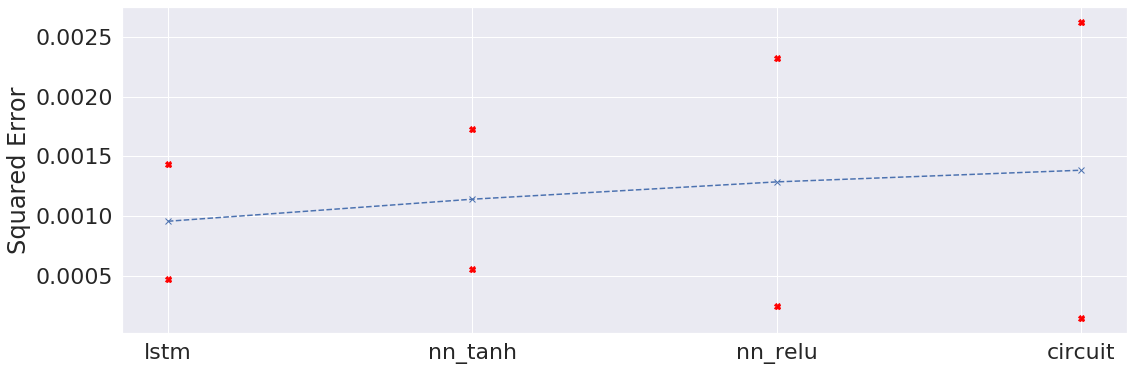

In [220]:
# plot means
# sns.set(font_scale=2.5) # plot font size
# fig = plt.figure(figsize=(18, 8))
# plt.title('Objective 2: MSE Considering Temperature');

fig, ax = plt.subplots(figsize=(18, 6)) 
df_costs = df_costs.reindex(df_costs.mean().sort_values().index, axis=1)


# plt.plot(df_costs.transpose(), 'o', markersize=30);
plt.plot(df_costs.mean(), '--x')
plt.plot(df_costs.mean() + df_costs.std(), 'X', color = 'red')
plt.plot(df_costs.mean() - df_costs.std(), 'X', color = 'red')
plt.ylabel('Squared Error');
# labels = list(df_costs.index)
# for label_idx in range(0, len(labels)):
#     labels[label_idx] = labels[label_idx].split('/')[-2] + " at " + labels[label_idx].split('/')[-3] + "°C"
# labels.append('mean')
# plt.legend(labels, loc=4, fontsize=20)
# plt.xlabel("Model")
# plt.ylabel("Cost")
# plt.tight_layout();

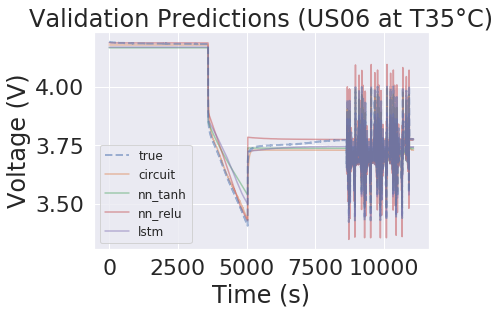

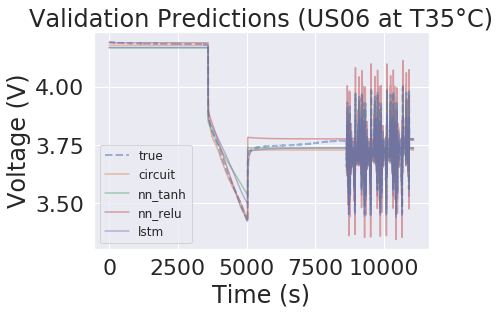

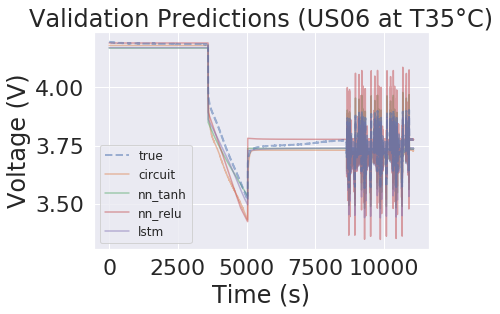

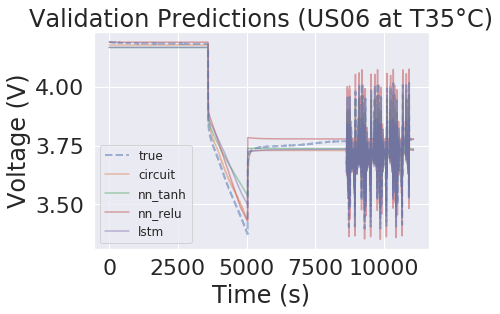

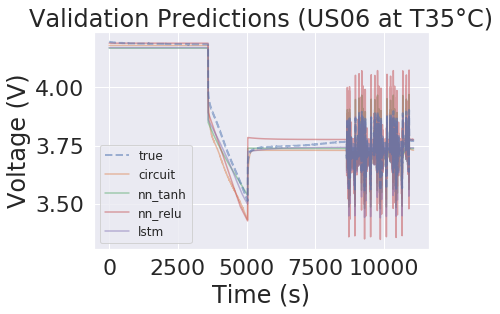

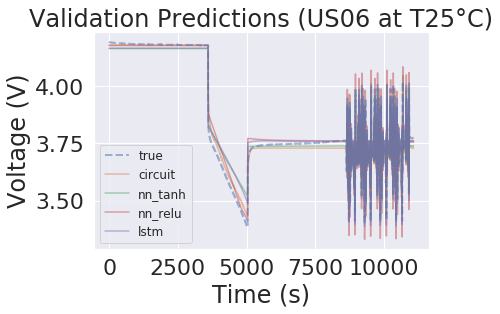

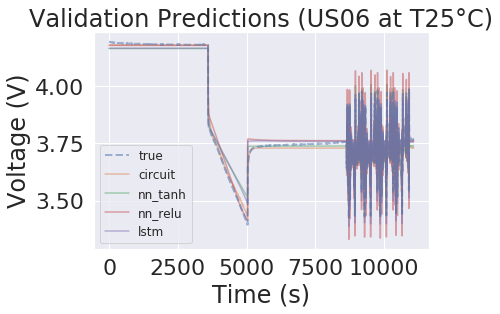

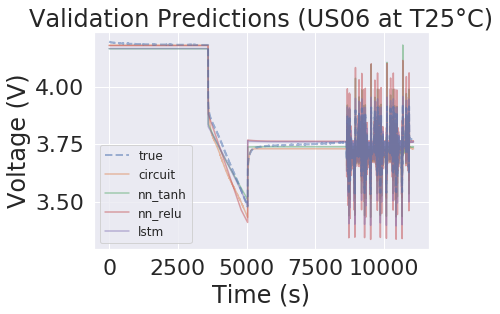

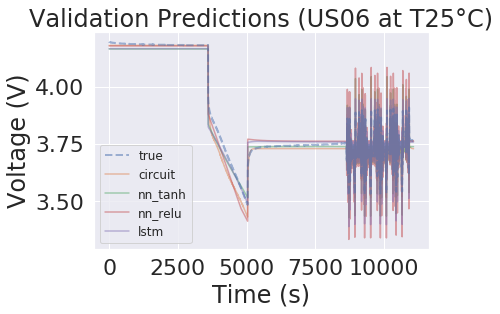

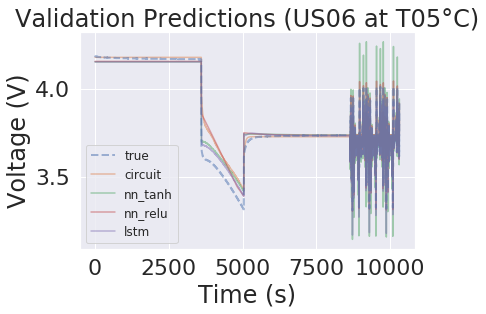

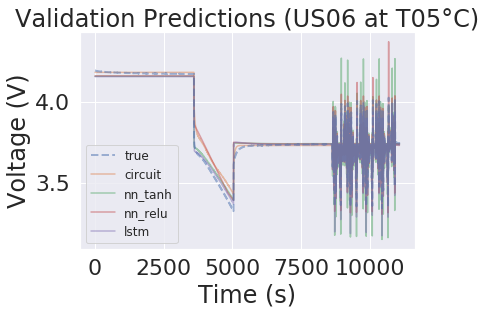

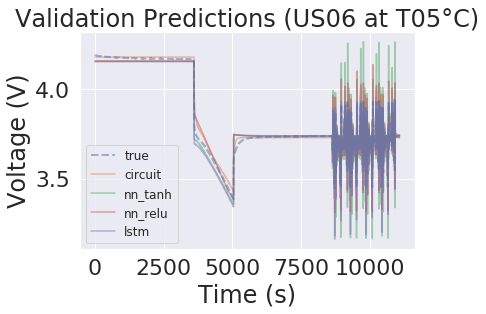

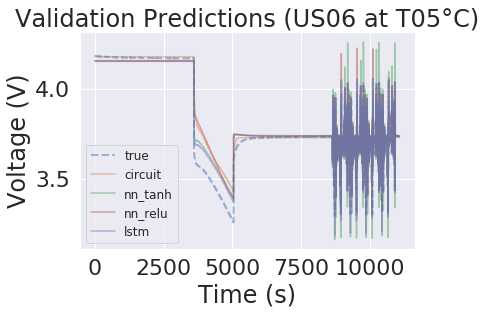

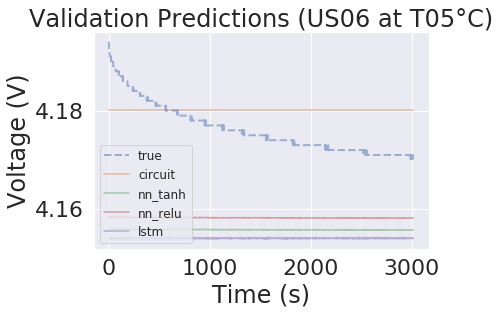

In [204]:
sns.set(font_scale=2) # plot font size
for dev_path in dev_paths:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    plt.plot(voltage, label='true', linewidth=2, linestyle='dashed', zorder=10, alpha=0.5)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(v_hat, label='circuit', alpha=0.5)
    
    # linear regression
    X = X_dev[['current_a','soc','temp_degc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(reg_pred, label='reg', alpha=0.5)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(tanh_pred, label='nn_tanh', alpha=0.5)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(relu_pred, label='nn_relu', alpha=0.5)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X).reshape(y.shape)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0)
    plt.plot(lstm_pred_padded, label='lstm', alpha=0.5)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Predictions ({})'.format(clean_dev_path))
    plt.legend(loc='lower left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')
    

In [205]:
dev_paths

['data/T35/US06/6.csv',
 'data/T35/US06/4.csv',
 'data/T35/US06/3.csv',
 'data/T35/US06/1.csv',
 'data/T35/US06/5.csv',
 'data/T25/US06/6.csv',
 'data/T25/US06/4.csv',
 'data/T25/US06/3.csv',
 'data/T25/US06/5.csv',
 'data/T05/US06/6.csv',
 'data/T05/US06/4.csv',
 'data/T05/US06/3.csv',
 'data/T05/US06/1.csv',
 'data/T05/US06/5.csv']

ValueError: shapes (11077,2) and (3,8) not aligned: 2 (dim 1) != 3 (dim 0)

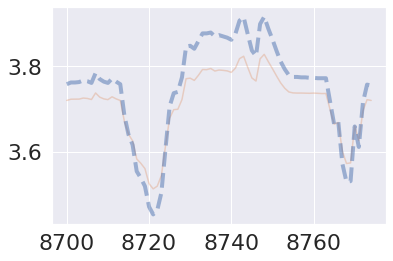

In [206]:
sns.set(font_scale=2) # plot font size
window_start = 8700
window_end = 8775
true_alpha = 0.5
other_alpha = 0.3
for dev_path in [dev_paths[1]]:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    plt.plot(np.arange(window_start, window_end), voltage[window_start:window_end], label='true', linewidth=4, linestyle='dashed', zorder=10, alpha=true_alpha)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(np.arange(window_start, window_end), v_hat[window_start:window_end], label='circuit', alpha=other_alpha)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(np.arange(window_start, window_end), reg_pred[window_start:window_end], label='reg', alpha=other_alpha)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), tanh_pred[window_start:window_end], label='nn_tanh', alpha=other_alpha)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), relu_pred[window_start:window_end], label='nn_relu', alpha=other_alpha)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X).reshape(y.shape)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0)
    plt.plot(np.arange(window_start, window_end), lstm_pred_padded[window_start:window_end], label='lstm', alpha=other_alpha)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Predictions ({})'.format(clean_dev_path))
    plt.legend(loc='lower left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')

In [ ]:
sns.set(font_scale=2) # plot font size
window_start = 3600
window_end = 3800
true_alpha = 0.5
other_alpha = 0.3
for dev_path in [dev_paths[2]]:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    plt.plot(np.arange(window_start, window_end), voltage[window_start:window_end], label='true', linewidth=4, linestyle='dashed', zorder=10, alpha=true_alpha)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(np.arange(window_start, window_end), v_hat[window_start:window_end], label='circuit', alpha=other_alpha)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(np.arange(window_start, window_end), reg_pred[window_start:window_end], label='reg', alpha=other_alpha)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), tanh_pred[window_start:window_end], label='nn_tanh', alpha=other_alpha)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), relu_pred[window_start:window_end], label='nn_relu', alpha=other_alpha)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X).reshape(y.shape)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0)
    plt.plot(np.arange(window_start, window_end), lstm_pred_padded[window_start:window_end], label='lstm', alpha=other_alpha)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Predictions ({})'.format(clean_dev_path))
    plt.legend(loc='lower left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')